# This is a notebook about predicting aurora

# 0. Data Downloading

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scripts.plotting import *

In [2]:
import calendar
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, seasonal_plot, month_plot
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "figure.figsize": (7,5), "lines.linewidth": 2})

In [3]:
# Downloading Kp Index data from https://www.gfz-potsdam.de/
from getKpindex import getKpindex

kpindex_data = getKpindex(starttime="1932-01-01", endtime=datetime.today().strftime('%Y-%m-%d'), index="Kp")

# 1. Exploratory Data Analysis

## 1.1 Data Loading and Cleaning
Let's first take a look at the dataset. Clean it if necessary, and try to make sense of the data. 

In [4]:
# Since kpindex_data is a transposed 2D list or array, transpose it back to the correct format.
kpindex_data_transposed = list(zip(*kpindex_data))

# Convert to a DataFrame
kpindex_df = pd.DataFrame(kpindex_data_transposed, columns=["Datetime", "Kp_Index", "Status"])

# Convert 'Datetime' to pandas datetime object
kpindex_df['Datetime'] = pd.to_datetime(kpindex_df['Datetime'])

kpindex_df.head()

Datetime  Kp_Index Status
0 1932-01-01 00:00:00+00:00     3.333    def
1 1932-01-01 03:00:00+00:00     2.667    def
2 1932-01-01 06:00:00+00:00     2.333    def
3 1932-01-01 09:00:00+00:00     2.667    def
4 1932-01-01 12:00:00+00:00     3.333    def

In [5]:
# Check for any missing data
kpindex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270952 entries, 0 to 270951
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   Datetime  270952 non-null  datetime64[ns, UTC]
 1   Kp_Index  270952 non-null  float64            
 2   Status    270952 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 6.2+ MB


In [6]:
# Check for missing values
kpindex_df.isnull().sum()

Datetime    0
Kp_Index    0
Status      0
dtype: int64

In [7]:
kpindex_df.describe()

Kp_Index
count  270952.00000
mean        2.16935
std         1.45156
min         0.00000
25%         1.00000
50%         2.00000
75%         3.00000
max         9.00000

There is a lot of data, from 1932 to present, and it's even broken into every 3 hours periods. Let's consolidate the data a little bit by taking the daily max Kp index, as we intend to predict Kp index for the next few days, not next few hours. 

In [8]:
# Create a new column for the date only
kpindex_df['Date'] = kpindex_df['Datetime'].dt.date

# Group by the 'Date' column and calculate the daily max and std of Kp index
daily_max_df = kpindex_df.groupby('Date').agg(Daily_Kp_max=('Kp_Index', 'max')).reset_index()

daily_max_df = pd.DataFrame(daily_max_df)

daily_max_df = daily_max_df.rename(columns={"Date": "Datetime", "Daily_Kp_max": "Kp_Index"})

daily_max_df.head()

Datetime  Kp_Index
0  1932-01-01     3.333
1  1932-01-02     5.000
2  1932-01-03     3.333
3  1932-01-04     2.000
4  1932-01-05     2.000

In [9]:
daily_max_df.describe()

Kp_Index
count  33869.000000
mean       3.385407
std        1.492864
min        0.000000
25%        2.333000
50%        3.333000
75%        4.333000
max        9.000000

There is three columns in the downloaded data, corresponding to the datetime of the record, the Kp index at the time, and whether it's a recorded or predicted value. There is no missing data in the datasets, so I won't need to perform any imputation. 

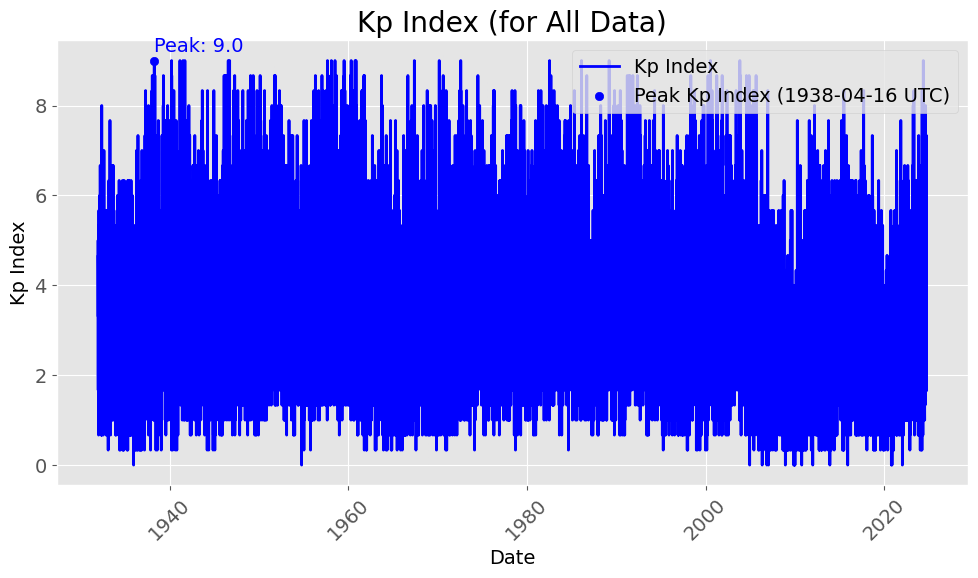

In [10]:
# To show all data:
plot_kp_index_by_date_range(daily_max_df)

This is a very large plot with many years of data. There doesn't seem to be an increase or decrease in max Kp index over the long timeframe, as suggested by an overall flat trend. 

Let's look at the annual max Kp index since 1932. 

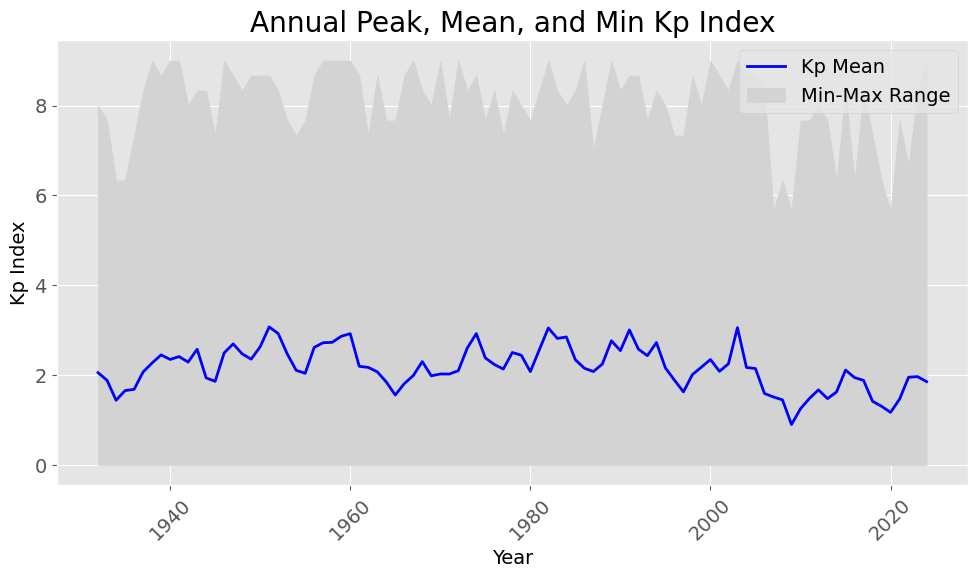

In [11]:
# Create a new column for the year
kpindex_df['Year'] = kpindex_df['Datetime'].dt.year

# Group by year and calculate max, min, and mean Kp index
annual_kp_df = kpindex_df.groupby('Year').agg(
    Kp_max=('Kp_Index', 'max'),
    Kp_min=('Kp_Index', 'min'),
    Kp_mean=('Kp_Index', 'mean')
).reset_index()

# Create a plot for the annual Kp Index (mean) with min-max range
plt.figure(figsize=(10, 6))

# Plot the mean Kp index
plt.plot(annual_kp_df['Year'], annual_kp_df['Kp_mean'], label="Kp Mean", color='blue')

# Fill between the min and max values to create a shaded area
plt.fill_between(annual_kp_df['Year'], annual_kp_df['Kp_min'], annual_kp_df['Kp_max'], color='lightgray', alpha=1, label="Min-Max Range")

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Kp Index')
plt.title("Annual Peak, Mean, and Min Kp Index")
plt.xticks(rotation=45)
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Between 1932 and 2024, the average annual Kp index doesn't seem to alter too much, but we can still observe a recent dip between 2009 and 2012, in both the max and mean Kp indices. This could be attributed to both technological reasons such as changing of the surveillance monitors or environmental reasons such as decreases in solar activities. 

For our downstream analysis, since we have an over-abundance of data, let's start by analyzing the data since 2000. This both alleviates the burden on our pipeline to take in all data and reduces the measurement errors attributed to different versions of monitors. 

In [12]:
# Filter the data for entries after 2000-01-01
daily_max_df_2000 = daily_max_df[daily_max_df['Datetime'] >= '2000-01-01'].reset_index(drop=True)

daily_max_df_2000.head()

Datetime  Kp_Index
0 2000-01-01     5.333
1 2000-01-02     3.333
2 2000-01-03     3.333
3 2000-01-04     3.667
4 2000-01-05     4.000

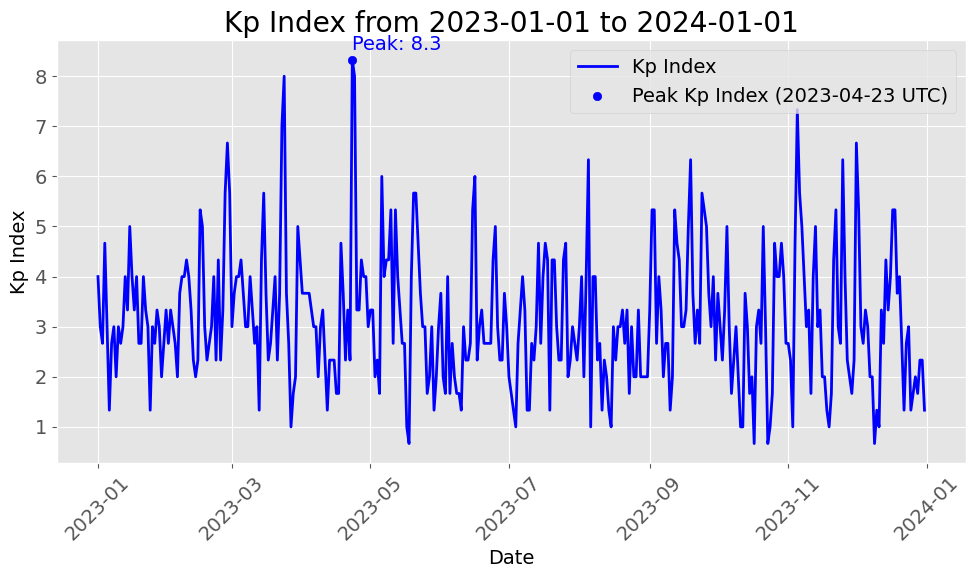

In [13]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df_2000, '2023-01-01', '2024-01-01')

There are ups and downs in the Kp Index but overall there isn't a upward or downward trend. 

Let's look at the past month only (August 2024). 

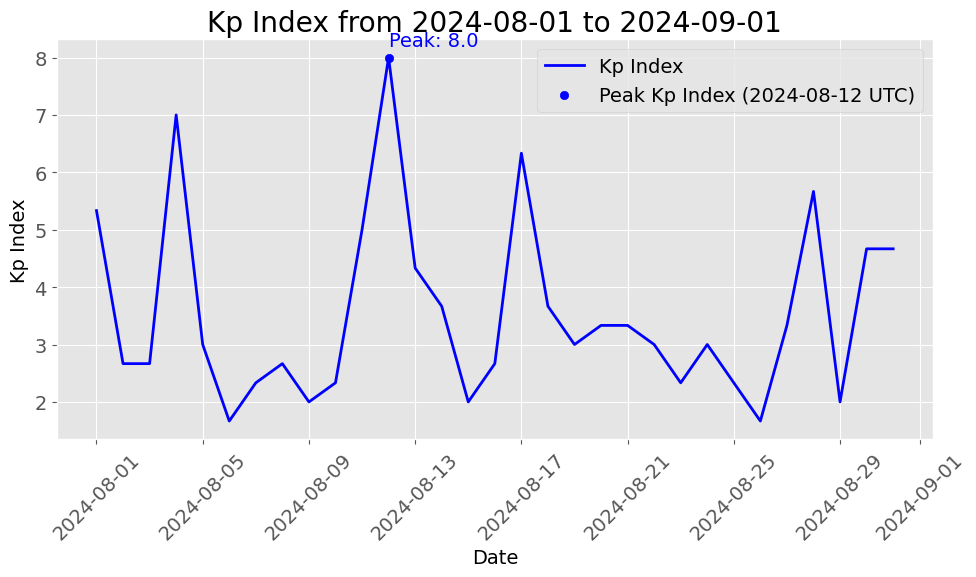

In [14]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df_2000, '2024-08-01', '2024-09-01')

Looks like there are variations of different widths. I personally was able to see aurora borealis on August 12th, 2024, which had the peak in Kp index. 

I saw another one in May 2024. Let's see if we can find it using the plot.

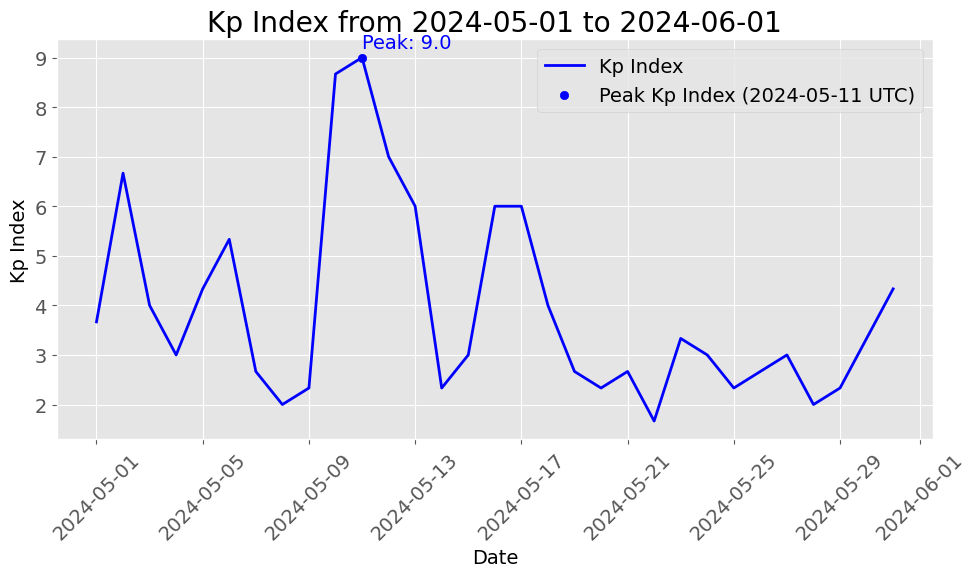

In [15]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df_2000, '2024-05-01', '2024-06-01')

What about in September 2024?

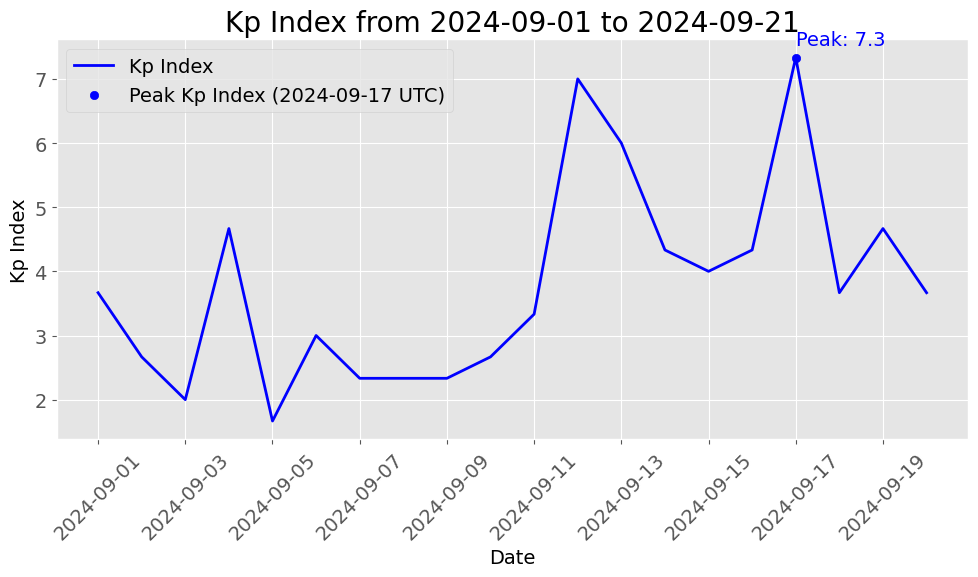

In [16]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df_2000, '2024-09-01', '2024-09-21')

## 1.2 Trends
With a lot of time-series data, there are temporal dependence, which maxs the value at a time is dependent on the value in the past. I will now take a look at this dependence, which is also called "autocorrelation". 

Firstly, let's examine if there are trends over the years. I'm going to try the polynomial with orders 0, 1, and 3 to try to capture the trend.

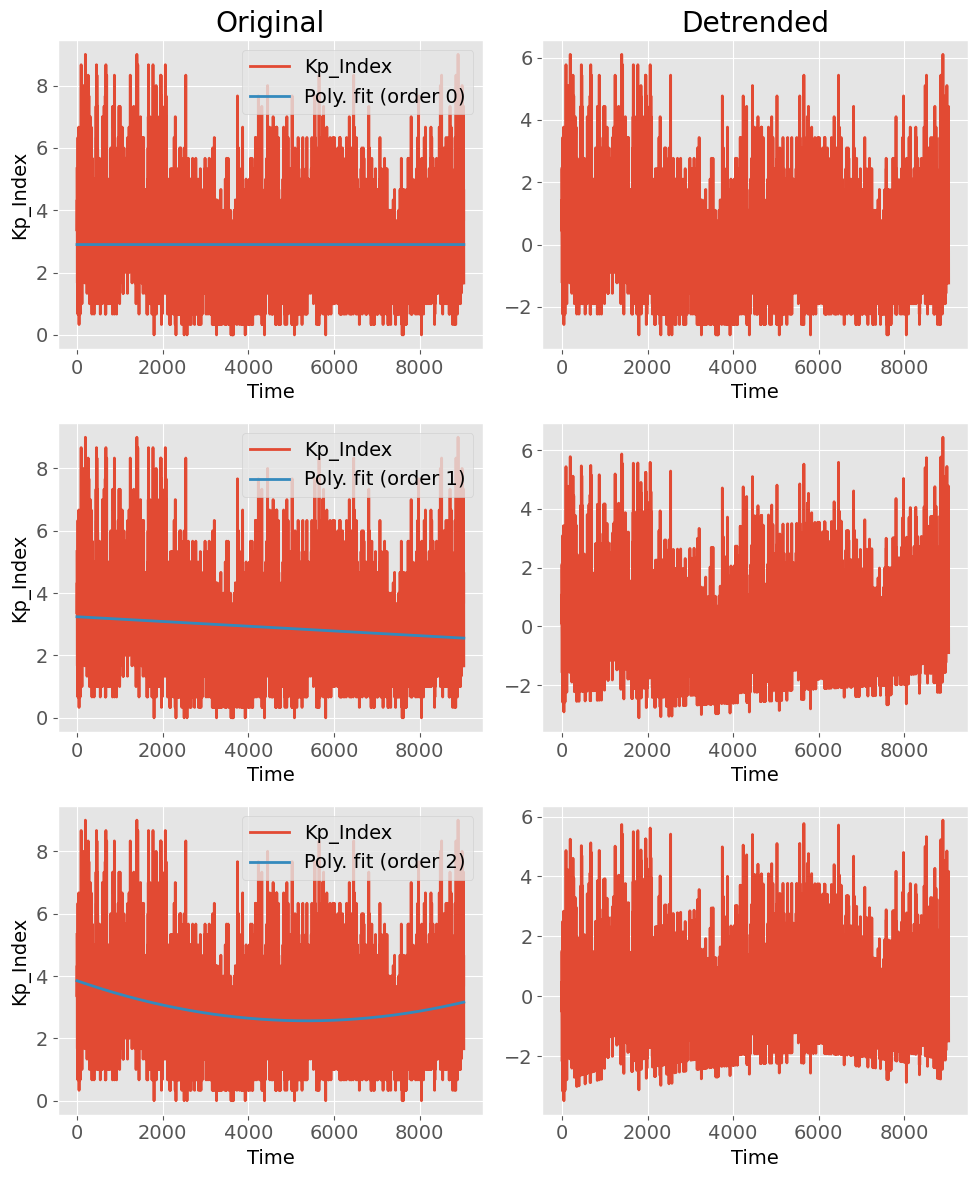

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for order in range(3):
    fit_label = f"Poly. fit (order {order})"
    daily_max_df_2000[fit_label] = daily_max_df_2000["Kp_Index"] - detrend(daily_max_df_2000["Kp_Index"], order=order)
    daily_max_df_2000[["Kp_Index", fit_label]].plot.line(xlabel="Time", ylabel="Kp_Index", ax=axes[order, 0])
    (daily_max_df_2000["Kp_Index"] - daily_max_df_2000[fit_label]).plot.line(xlabel="Time", legend=False, ax=axes[order, 1])
axes[0, 0].set_title("Original")
axes[0, 1].set_title("Detrended")
plt.tight_layout();

Looks like the polynomial fit of order 0 is already working pretty well. I guess the data over the entire period of time isn't increaseing or decreasing. The lines oscillates around Kp_Index of `2.8987793`, as indicated in the `Poly. fit (order 0)`. We can use detrending to remove this. 

In [18]:
daily_max_df_2000['detrended'] = daily_max_df_2000["Kp_Index"] - daily_max_df_2000['Poly. fit (order 0)']
daily_max_df_2000.head()

Datetime  Kp_Index  Poly. fit (order 0)  Poly. fit (order 1)  \
0 2000-01-01     5.333             2.898657             3.241603   
1 2000-01-02     3.333             2.898657             3.241527   
2 2000-01-03     3.333             2.898657             3.241451   
3 2000-01-04     3.667             2.898657             3.241375   
4 2000-01-05     4.000             2.898657             3.241299   

   Poly. fit (order 2)  detrended  
0             3.848257   2.434343  
1             3.847778   0.434343  
2             3.847299   0.434343  
3             3.846820   0.768343  
4             3.846342   1.101343

By subtracting all daily values with `2.898793`, the lines should converge to 0, shown by the detrended polynomial 0 graph (top right). 

## 1.3 Seasonality

Let's do some exploration first. I'm curious to see how the peak Kp index repeat over days in a month, and months in a year and .

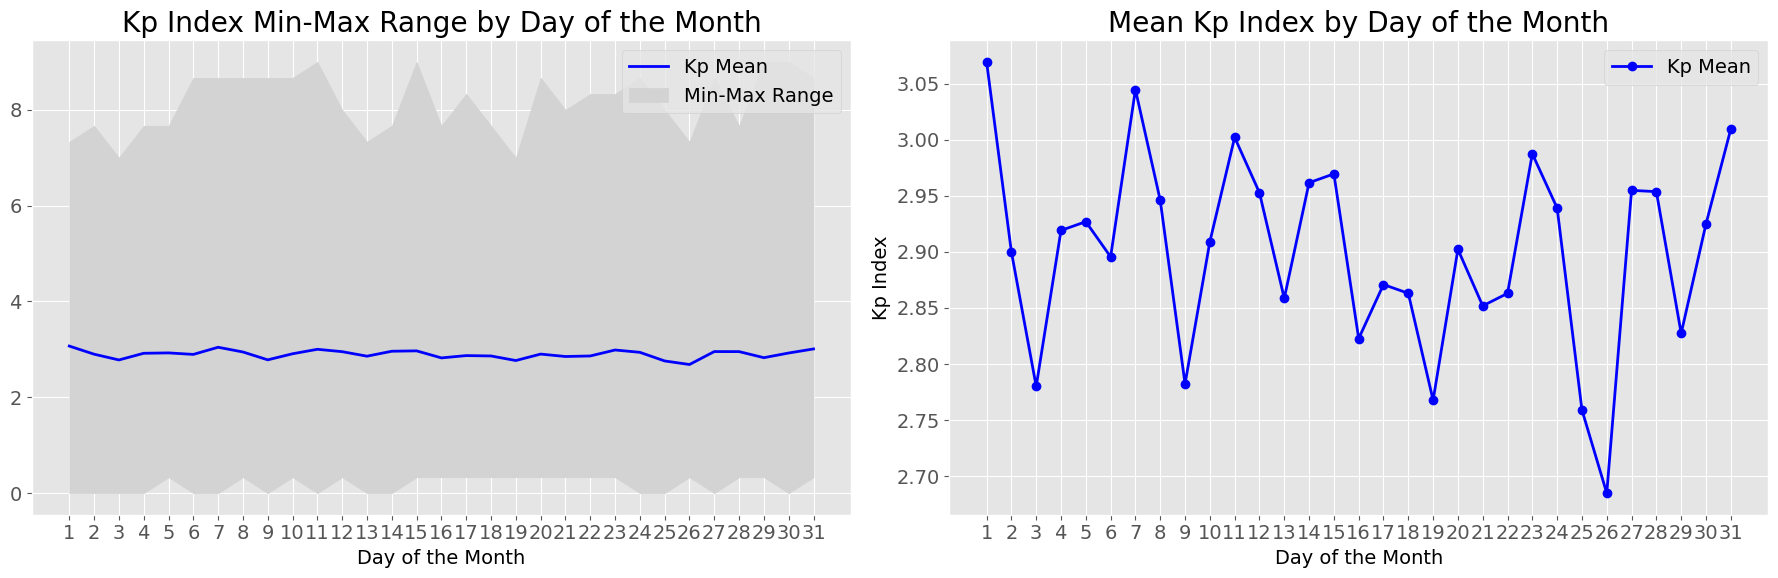

In [19]:
# Group by day of the month and calculate the mean, min, and max
day_of_month = daily_max_df_2000.groupby(daily_max_df_2000['Datetime'].dt.day).agg(
    Mean_dayofmonth_peak_Kp=('Kp_Index', 'mean'), 
    Min_dayofmonth_peak_Kp=('Kp_Index', 'min'), 
    Max_dayofmonth_peak_Kp=('Kp_Index', 'max')
).reset_index()

# Rename the 'Datetime' column to 'Day' since we are grouping by the day of the month
day_of_month.rename(columns={'Datetime': 'Day_of_Month'}, inplace=True)

# Create subplots with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot min, mean, max Kp index
axes[0].plot(day_of_month['Day_of_Month'], day_of_month['Mean_dayofmonth_peak_Kp'], label="Kp Mean", color='blue')
axes[0].fill_between(day_of_month['Day_of_Month'], day_of_month['Min_dayofmonth_peak_Kp'], day_of_month['Max_dayofmonth_peak_Kp'], color='lightgray', alpha=1, label="Min-Max Range")
axes[0].set_xlabel('Day of the Month')
axes[0].set_title("Kp Index Min-Max Range by Day of the Month")
axes[0].set_xticks(range(1, 32))
axes[0].legend()

# Plot mean Kp index
axes[1].plot(day_of_month['Day_of_Month'], day_of_month['Mean_dayofmonth_peak_Kp'], label="Kp Mean", color='blue', marker="o")
axes[1].set_xlabel('Day of the Month')
axes[1].set_ylabel('Kp Index')
axes[1].set_title("Mean Kp Index by Day of the Month")
axes[1].set_xticks(range(1, 32))
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


We can see the variation for day of a month is not too striking. Although the right graph showed ups and downs, keep in mind of the y axis. 

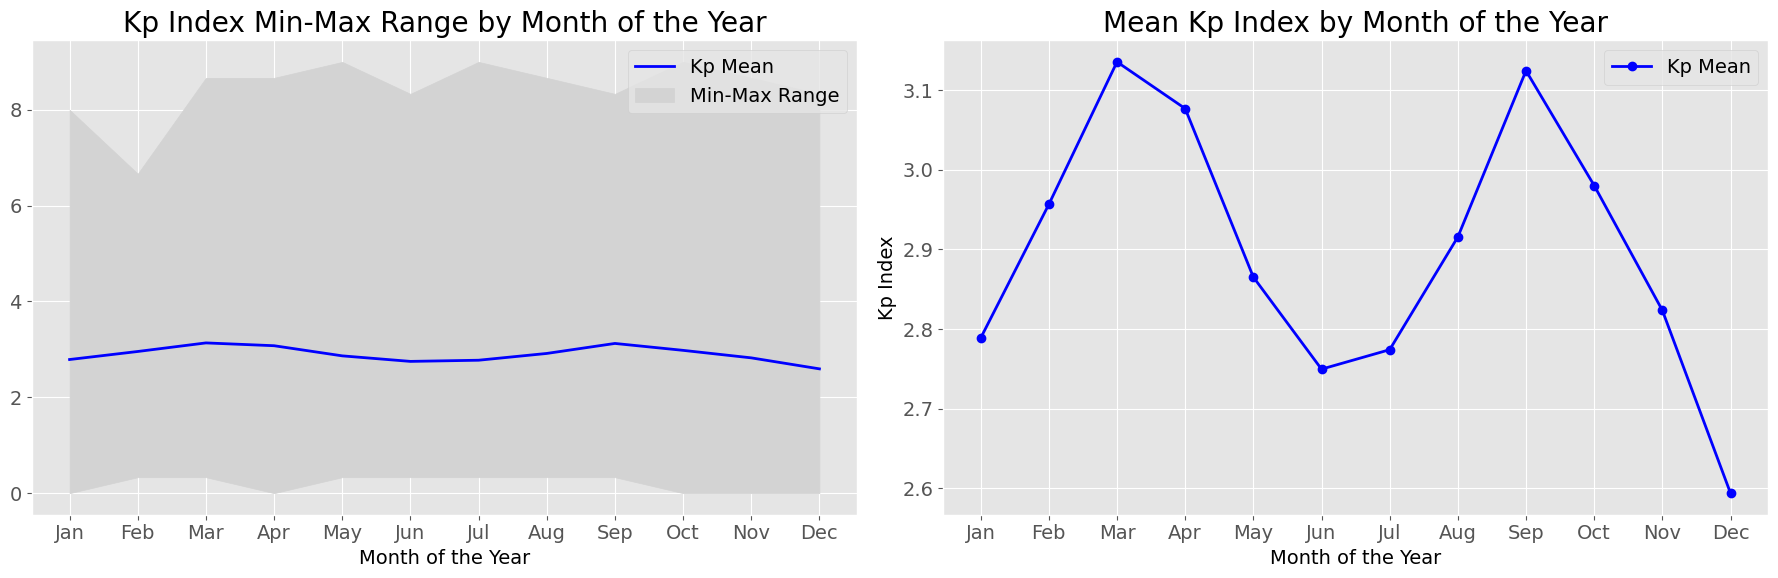

In [20]:
# Group by month of the year and calculate the mean, min, and max
month_of_year = daily_max_df_2000.groupby(daily_max_df_2000['Datetime'].dt.month).agg(
    Mean_monthly_peak_Kp=('Kp_Index', 'mean'), 
    Min_monthly_peak_Kp=('Kp_Index', 'min'), 
    Max_monthly_peak_Kp=('Kp_Index', 'max')
).reset_index()

# Rename the 'Datetime' column to 'Month' since we are grouping by the month of the year
month_of_year.rename(columns={'Datetime': 'Month'}, inplace=True)

# Create subplots with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot min, mean, max Kp index
axes[0].plot(month_of_year['Month'], month_of_year['Mean_monthly_peak_Kp'], label="Kp Mean", color='blue')
axes[0].fill_between(month_of_year['Month'], month_of_year['Min_monthly_peak_Kp'], month_of_year['Max_monthly_peak_Kp'], color='lightgray', alpha=1, label="Min-Max Range")
axes[0].set_xlabel('Month of the Year')
axes[0].set_title("Kp Index Min-Max Range by Month of the Year")
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
axes[0].legend()

# Plot mean Kp index
axes[1].plot(month_of_year['Month'], month_of_year['Mean_monthly_peak_Kp'], label="Kp Mean", color='blue', marker="o")
axes[1].set_xlabel('Month of the Year')
axes[1].set_ylabel('Kp Index')
axes[1].set_title("Mean Kp Index by Month of the Year")
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


We can see that for months in a year, the Kp index varies a bit more than days of a month. It tends to peak during March and September, and dips around between June to July and December to January. 

Let's save both month of a year and day of a month as additional features in the dataframe. 

In [21]:
daily_max_df_2000 = daily_max_df_2000.merge(day_of_month, left_on=daily_max_df_2000['Datetime'].dt.day, right_on='Day_of_Month', how='left')
daily_max_df_2000 = daily_max_df_2000.merge(month_of_year, left_on=daily_max_df_2000['Datetime'].dt.month, right_on='Month', how='left')

daily_max_df_2000.head()

Datetime  Kp_Index  Poly. fit (order 0)  Poly. fit (order 1)  \
0 2000-01-01     5.333             2.898657             3.241603   
1 2000-01-02     3.333             2.898657             3.241527   
2 2000-01-03     3.333             2.898657             3.241451   
3 2000-01-04     3.667             2.898657             3.241375   
4 2000-01-05     4.000             2.898657             3.241299   

   Poly. fit (order 2)  detrended  Day_of_Month  Mean_dayofmonth_peak_Kp  \
0             3.848257   2.434343             1                 3.069596   
1             3.847778   0.434343             2                 2.900118   
2             3.847299   0.434343             3                 2.780020   
3             3.846820   0.768343             4                 2.919199   
4             3.846342   1.101343             5                 2.927017   

   Min_dayofmonth_peak_Kp  Max_dayofmonth_peak_Kp  Month  \
0                   0.000                   7.333      1   
1                   0.000                   7.667      1   
2                   0.000                   7.000      1   
3                   0.000                   7.667      1   
4                   0.333                   7.667      1   

   Mean_monthly_peak_Kp  Min_monthly_peak_Kp  Max_monthly_peak_Kp  
0              2.788832                  0.0                  8.0  
1              2.788832                  0.0                  8.0  
2              2.788832                  0.0                  8.0  
3              2.788832                  0.0                  8.0  
4              2.788832                  0.0                  8.0

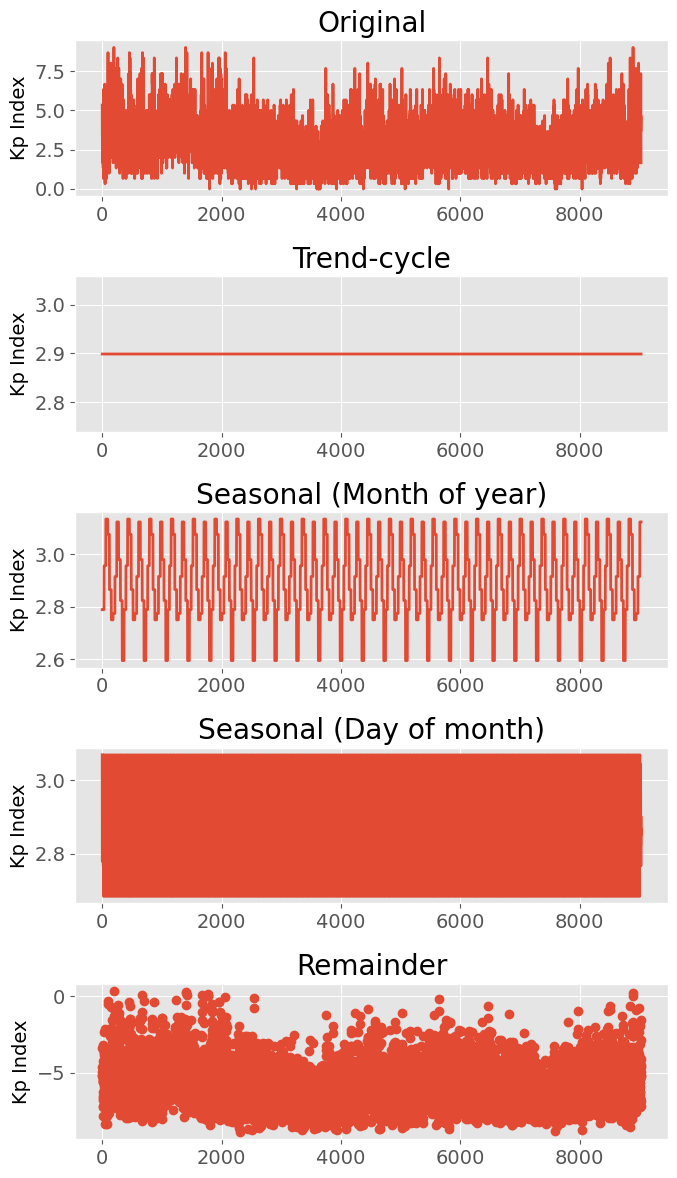

In [22]:
# Estimating the remainder
daily_max_df_2000["remainder"] = daily_max_df_2000["Kp_Index"] - daily_max_df_2000["Poly. fit (order 0)"] - daily_max_df_2000["Mean_monthly_peak_Kp"] - daily_max_df_2000["Mean_dayofmonth_peak_Kp"]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(7, 12))
daily_max_df_2000["Kp_Index"].plot.line(ylabel="Kp Index", title="Original", xlabel="", ax=axes[0])
daily_max_df_2000["Poly. fit (order 0)"].plot.line(ylabel="Kp Index", title="Trend-cycle", xlabel="", ax=axes[1])
daily_max_df_2000["Mean_monthly_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Month of year)", xlabel="", ax=axes[2])
daily_max_df_2000["Mean_dayofmonth_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Day of month)", xlabel="", ax=axes[3])
daily_max_df_2000["remainder"].plot.line(ylabel="Kp Index", title="Remainder", ax=axes[4], marker="o", linestyle="")
plt.tight_layout();

We can see that the remainder doesn't look very stationary after the deletions. 

The next tool we have in testing for seasonality is using the autocorrelation function `acf` and `pacf`. It looks for any correlations in the time-series data. 

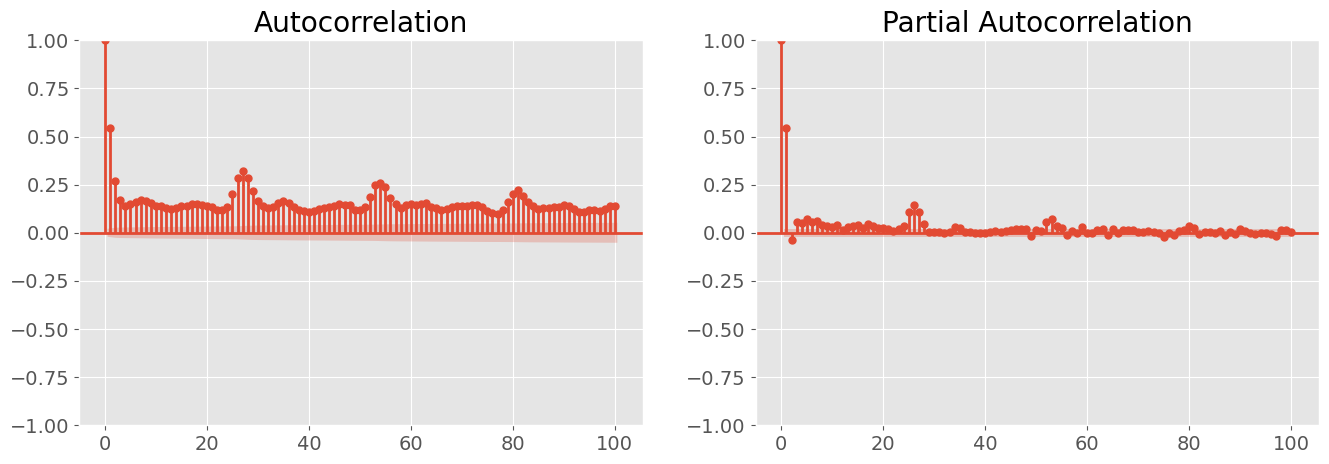

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_acf(daily_max_df_2000["remainder"], lags=100, ax=axes[0])
plot_pacf(daily_max_df_2000["remainder"], lags=100, ax=axes[1]);

There is autocorrelation around every 25-30 lags. Maybe this correlates with the cycle of the Sun (the Sun rotates on its axis once in 27 days)? 

Since the ACF value drops rapidly after lag 3, the autocorrelation is very strong.

Let's extract the exact lag value first. 

In [24]:
acf_data = acf(daily_max_df_2000["Kp_Index"], nlags=100, bartlett_confint=True)

# Create lags array
lags = np.arange(len(acf_data))

# Define the range to find the highest point
start_lag = 20
end_lag = 40

# Find indices within the specified lag range
indices_within_range = np.where((lags >= start_lag) & (lags <= end_lag))[0]

# Find the maximum ACF value within this range
max_index = indices_within_range[np.argmax(acf_data[indices_within_range])]
max_lag = lags[max_index]
max_acf_value = acf_data[max_index]

print(f'The maximum ACF value is at lag {max_lag} with a value of {max_acf_value}.')

The maximum ACF value is at lag 27 with a value of 0.3237345258613246.


I can label this onto the ACF plot. 

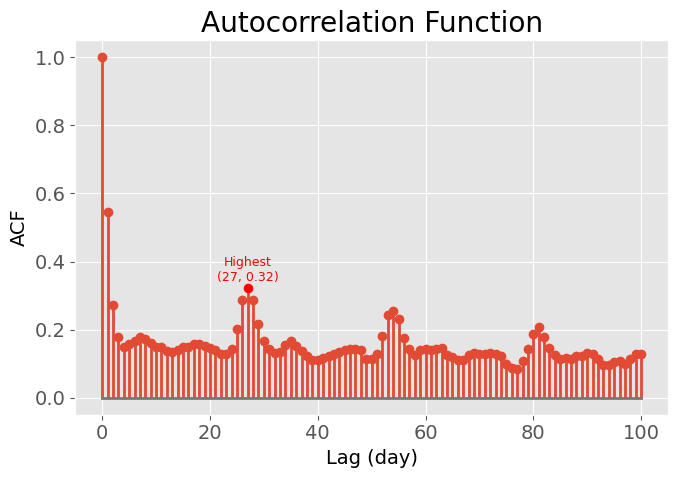

In [25]:
# Plot ACF
plt.stem(lags, acf_data, use_line_collection=True)
plt.xlabel("Lag (day)")
plt.ylabel('ACF')

# Annotate the highest point
plt.scatter(max_lag, max_acf_value, color='red', zorder=5)
plt.text(max_lag, max_acf_value + 0.02, f'Highest\n({max_lag}, {max_acf_value:.2f})',
         color='red', fontsize=9, ha='center')

plt.title('Autocorrelation Function')
plt.tight_layout()
plt.show()

Let's explore how the Kp index repeats every 27 days.

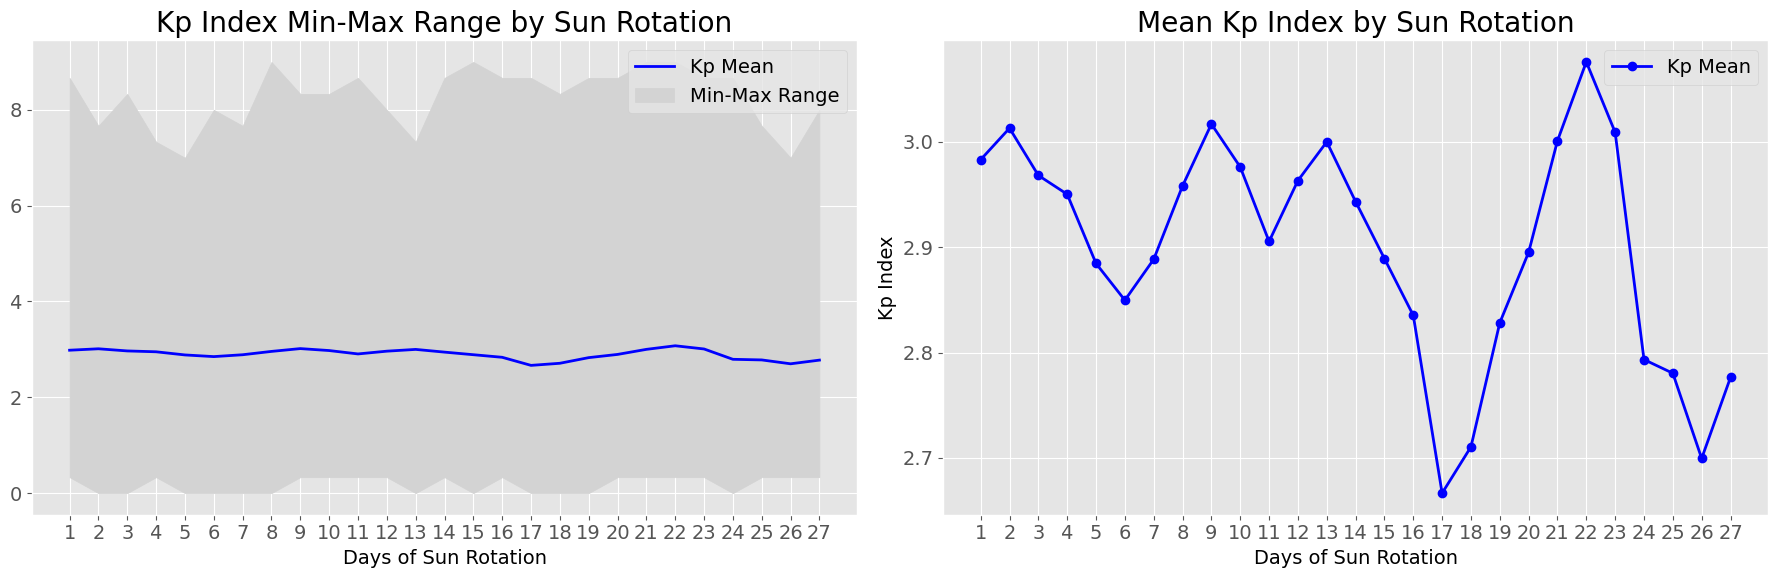

In [26]:
# Create a 27-day period identifier based on the day of the dataset
daily_max_df_2000['Day_Sun_rotation'] = daily_max_df_2000.index % 27 +1  # Grouping every 27 days
sun_rotation = daily_max_df_2000.groupby(daily_max_df_2000['Day_Sun_rotation']).agg(
    Mean_sunrotation_peak_Kp=('Kp_Index', 'mean'), 
    Min_sunrotation_peak_Kp=('Kp_Index', 'min'), 
    Max_sunrotation_peak_Kp=('Kp_Index', 'max')
).reset_index()

# Create subplots with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot min, mean, max Kp index
axes[0].plot(sun_rotation['Day_Sun_rotation'], sun_rotation['Mean_sunrotation_peak_Kp'], label="Kp Mean", color='blue')
axes[0].fill_between(sun_rotation['Day_Sun_rotation'], sun_rotation['Min_sunrotation_peak_Kp'], sun_rotation['Max_sunrotation_peak_Kp'], color='lightgray', alpha=1, label="Min-Max Range")
axes[0].set_xlabel('Days of Sun Rotation')
axes[0].set_title("Kp Index Min-Max Range by Sun Rotation")
axes[0].set_xticks(range(1, 28))
axes[0].legend()

# Plot mean Kp index
axes[1].plot(sun_rotation['Day_Sun_rotation'], sun_rotation['Mean_sunrotation_peak_Kp'], label="Kp Mean", color='blue', marker="o")
axes[1].set_xlabel('Days of Sun Rotation')
axes[1].set_ylabel('Kp Index')
axes[1].set_title("Mean Kp Index by Sun Rotation")
axes[1].set_xticks(range(1, 28))
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


We can see that there are some variations of average Kp index in the 27 day period, especially a large variation between day 17 and 22. However, keep in mind of the scale of these changes, which is only from 2.6 to 3.2. 

There is also the solar cycle, which lasts for 11 years. Let's explore that

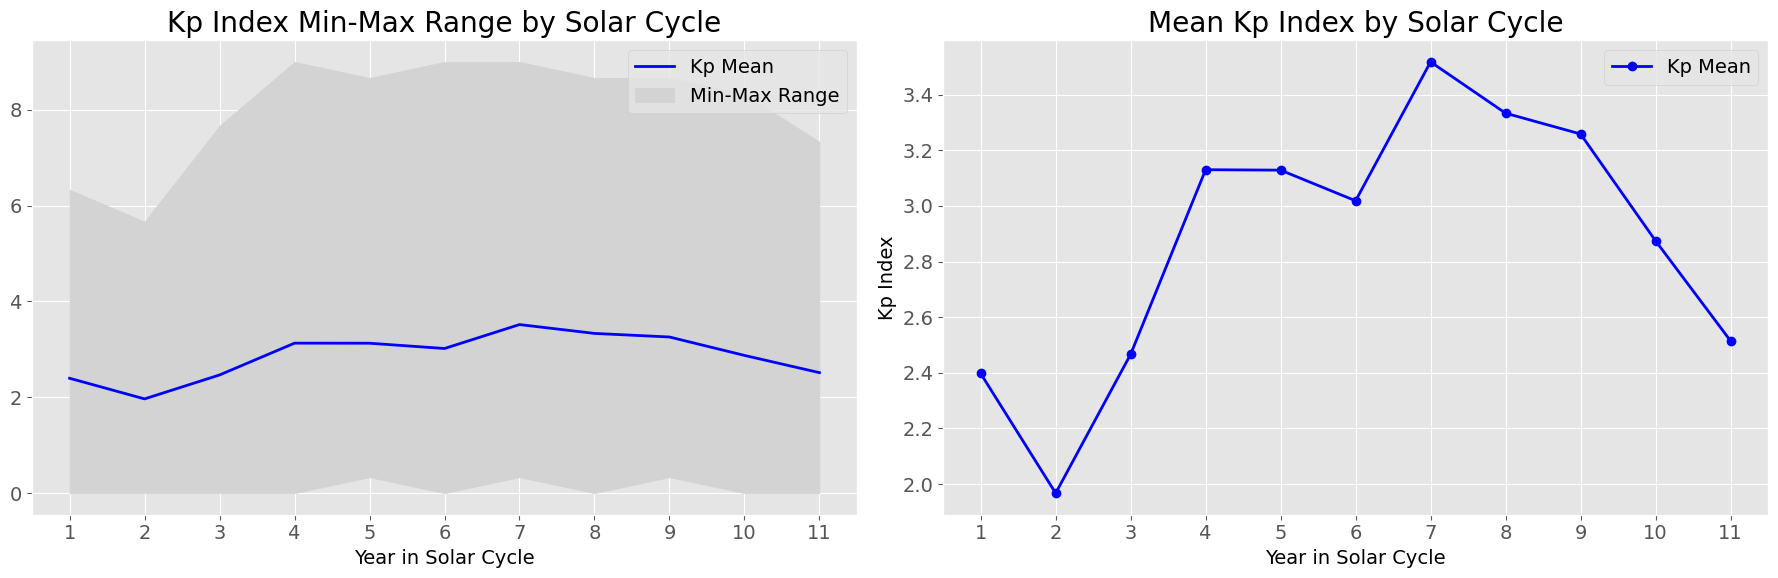

In [27]:
# Create an 11-year period identifier based on the year. As the first conventionally stated solar cycle began in 1755. 
# We subtract 1755 from each year to indicate which year is it at during a solar cycle. 
daily_max_df_2000['Year'] = daily_max_df_2000['Datetime'].dt.year
daily_max_df_2000['11_Year_Group'] = (daily_max_df_2000['Year'] - 1755) % 11 + 1

solar_cycle = daily_max_df_2000.groupby(daily_max_df_2000['11_Year_Group']).agg(
    Mean_solarcycle_peak_Kp=('Kp_Index', 'mean'), 
    Min_solarcycle_peak_Kp=('Kp_Index', 'min'), 
    Max_solarcycle_peak_Kp=('Kp_Index', 'max')
).reset_index()

# Create subplots with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot min, mean, max Kp index
axes[0].plot(solar_cycle['11_Year_Group'], solar_cycle['Mean_solarcycle_peak_Kp'], label="Kp Mean", color='blue')
axes[0].fill_between(solar_cycle['11_Year_Group'], solar_cycle['Min_solarcycle_peak_Kp'], solar_cycle['Max_solarcycle_peak_Kp'], color='lightgray', alpha=1, label="Min-Max Range")
axes[0].set_xlabel('Year in Solar Cycle')
axes[0].set_title("Kp Index Min-Max Range by Solar Cycle")
axes[0].set_xticks(range(1, 12))
axes[0].legend()

# Plot mean Kp index
axes[1].plot(solar_cycle['11_Year_Group'], solar_cycle['Mean_solarcycle_peak_Kp'], label="Kp Mean", color='blue', marker="o")
axes[1].set_xlabel('Year in Solar Cycle')
axes[1].set_ylabel('Kp Index')
axes[1].set_title("Mean Kp Index by Solar Cycle")
axes[1].set_xticks(range(1, 12))
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

The variations in mean solar cycle Kp are greater than that in the 27 day solar rolation, ranging between 2.0 to 3.5. Let's merge these two dataframes with the `daily_max_df_2000` and perform the manual removal of autocorrelation.

In [28]:
daily_max_df_2000 = daily_max_df_2000.merge(sun_rotation, left_on=daily_max_df_2000['Day_Sun_rotation'], right_on='Day_Sun_rotation', how='left')
daily_max_df_2000 = daily_max_df_2000.merge(solar_cycle, left_on=daily_max_df_2000['11_Year_Group'], right_on='11_Year_Group', how='left')

daily_max_df_2000.head()

11_Year_Group  Day_Sun_rotation   Datetime  Kp_Index  Poly. fit (order 0)  \
0              4                 1 2000-01-01     5.333             2.898657   
1              4                 2 2000-01-02     3.333             2.898657   
2              4                 3 2000-01-03     3.333             2.898657   
3              4                 4 2000-01-04     3.667             2.898657   
4              4                 5 2000-01-05     4.000             2.898657   

   Poly. fit (order 1)  Poly. fit (order 2)  detrended  Day_of_Month  \
0             3.241603             3.848257   2.434343             1   
1             3.241527             3.847778   0.434343             2   
2             3.241451             3.847299   0.434343             3   
3             3.241375             3.846820   0.768343             4   
4             3.241299             3.846342   1.101343             5   

   Mean_dayofmonth_peak_Kp  ...  Year  11_Year_Group_x  Day_Sun_rotation_y  \
0                 3.069596  ...  2000                4                   1   
1                 2.900118  ...  2000                4                   2   
2                 2.780020  ...  2000                4                   3   
3                 2.919199  ...  2000                4                   4   
4                 2.927017  ...  2000                4                   5   

   Mean_sunrotation_peak_Kp  Min_sunrotation_peak_Kp  Max_sunrotation_peak_Kp  \
0                  2.983078                    0.333                    8.667   
1                  3.012973                    0.000                    7.667   
2                  2.968164                    0.000                    8.333   
3                  2.950257                    0.333                    7.333   
4                  2.884567                    0.000                    7.000   

   11_Year_Group_y  Mean_solarcycle_peak_Kp  Min_solarcycle_peak_Kp  \
0                4                 3.130476                     0.0   
1                4                 3.130476                     0.0   
2                4                 3.130476                     0.0   
3                4                 3.130476                     0.0   
4                4                 3.130476                     0.0   

   Max_solarcycle_peak_Kp  
0                     9.0  
1                     9.0  
2                     9.0  
3                     9.0  
4                     9.0  

[5 rows x 28 columns]

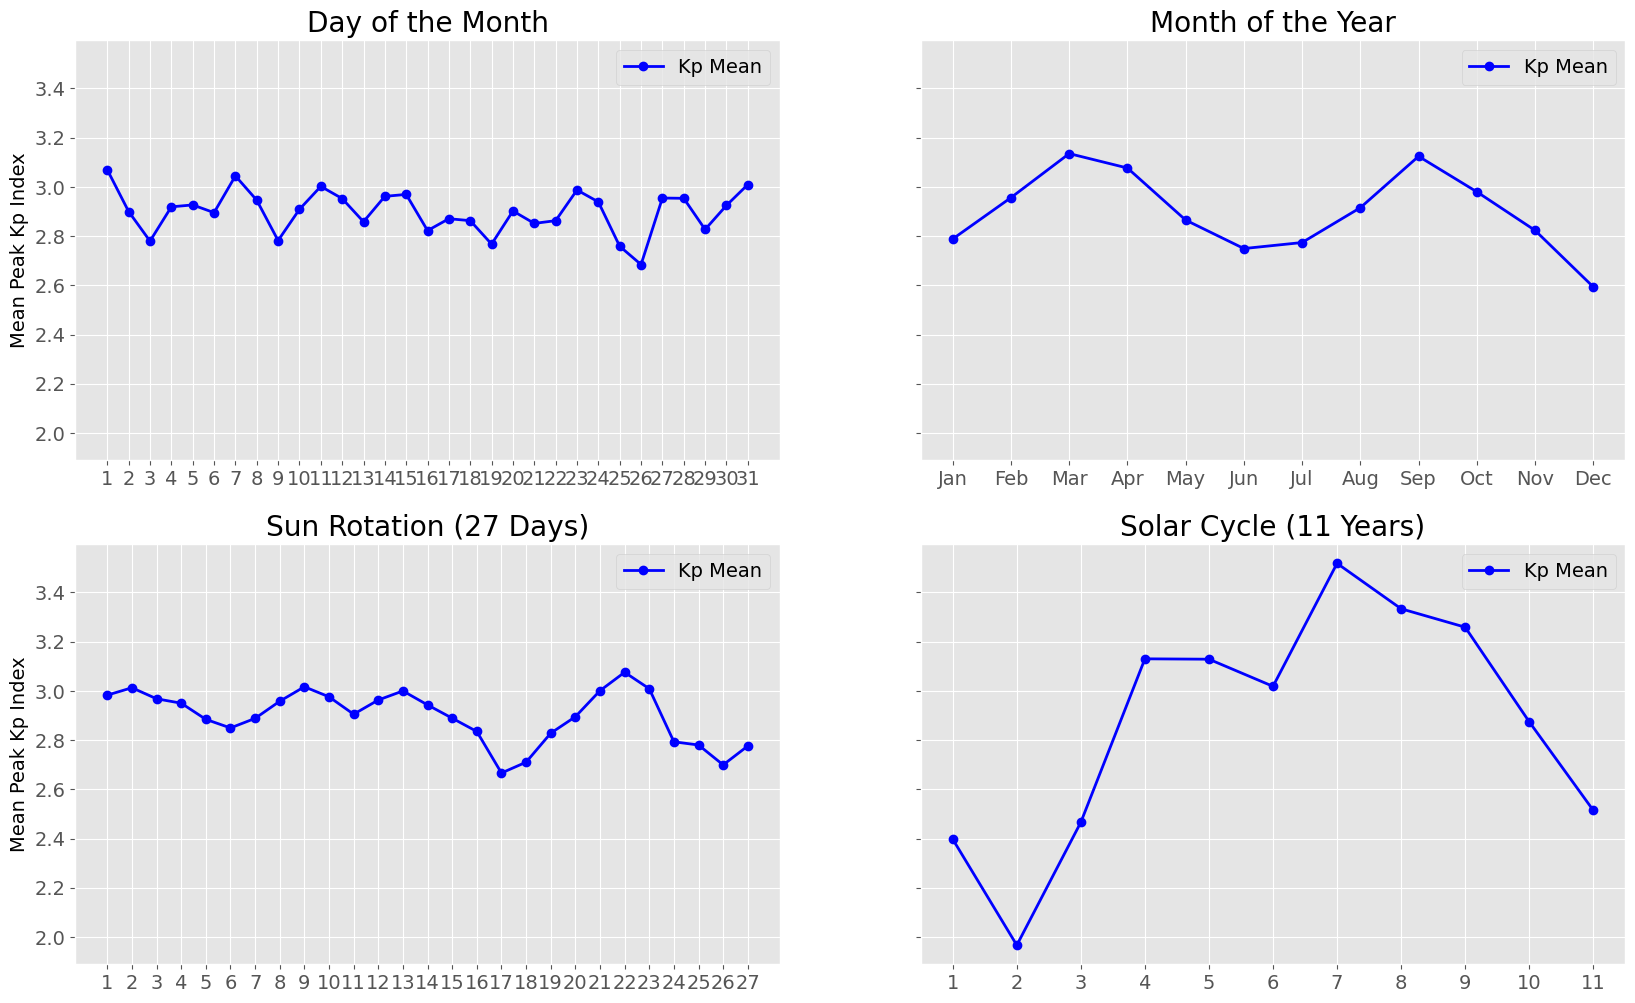

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey='all')
# Plot mean Kp index
axes[0,0].plot(day_of_month['Day_of_Month'], day_of_month['Mean_dayofmonth_peak_Kp'], label="Kp Mean", color='blue', marker="o")
# axes[0,0].set_xlabel('Day of the Month')
axes[0,0].set_ylabel('Mean Peak Kp Index')
axes[0,0].set_title("Day of the Month")
axes[0,0].set_xticks(range(1, 32))
axes[0,0].legend()

# Plot mean Kp index
axes[0,1].plot(month_of_year['Month'], month_of_year['Mean_monthly_peak_Kp'], label="Kp Mean", color='blue', marker="o")
# axes[0,1].set_xlabel('Month of the Year')
# axes[0,1].set_ylabel('Kp Index')
axes[0,1].set_title("Month of the Year")
axes[0,1].set_xticks(range(1, 13))
axes[0,1].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
axes[0,1].legend()

# Plot mean Kp index
axes[1,0].plot(sun_rotation['Day_Sun_rotation'], sun_rotation['Mean_sunrotation_peak_Kp'], label="Kp Mean", color='blue', marker="o")
# axes[1,0].set_xlabel('Days of Sun Rotation')
axes[1,0].set_ylabel('Mean Peak Kp Index')
axes[1,0].set_title("Sun Rotation (27 Days)")
axes[1,0].set_xticks(range(1, 28))
axes[1,0].legend()


# Plot mean Kp index
axes[1,1].plot(solar_cycle['11_Year_Group'], solar_cycle['Mean_solarcycle_peak_Kp'], label="Kp Mean", color='blue', marker="o")
# axes[1,1].set_xlabel('Year in Solar Cycle')
# axes[1,1].set_ylabel('Kp Index')
axes[1,1].set_title("Solar Cycle (11 Years)")
axes[1,1].set_xticks(range(1, 12))
axes[1,1].legend()


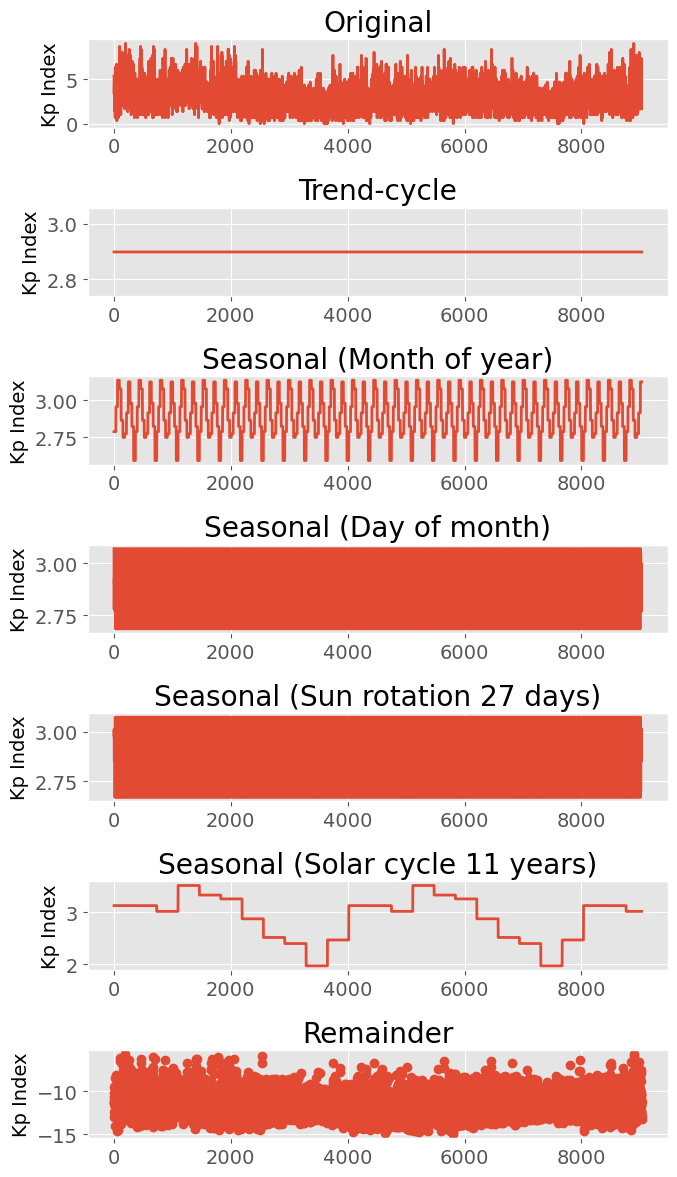

In [30]:
# Adding two more subtractions to the remainder
daily_max_df_2000["remainder"] = (
    daily_max_df_2000["Kp_Index"]
    - daily_max_df_2000["Poly. fit (order 0)"]
    - daily_max_df_2000["Mean_monthly_peak_Kp"]
    - daily_max_df_2000["Mean_dayofmonth_peak_Kp"]
    - daily_max_df_2000["Mean_sunrotation_peak_Kp"]
    - daily_max_df_2000["Mean_solarcycle_peak_Kp"]
)

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(7, 12))
daily_max_df_2000["Kp_Index"].plot.line(ylabel="Kp Index", title="Original", xlabel="", ax=axes[0])
daily_max_df_2000["Poly. fit (order 0)"].plot.line(ylabel="Kp Index", title="Trend-cycle", xlabel="", ax=axes[1])
daily_max_df_2000["Mean_monthly_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Month of year)", xlabel="", ax=axes[2])
daily_max_df_2000["Mean_dayofmonth_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Day of month)", xlabel="", ax=axes[3])
daily_max_df_2000["Mean_sunrotation_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Sun rotation 27 days)", xlabel="", ax=axes[4])
daily_max_df_2000["Mean_solarcycle_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Solar cycle 11 years)", xlabel="", ax=axes[5])
daily_max_df_2000["remainder"].plot.line(ylabel="Kp Index", title="Remainder", ax=axes[6], marker="o", linestyle="")
plt.tight_layout();

After these detrending and deseasonality methods, the remainder looks much more stationary than before. 

Let's validate with the `acf` and `pacf` methods. 

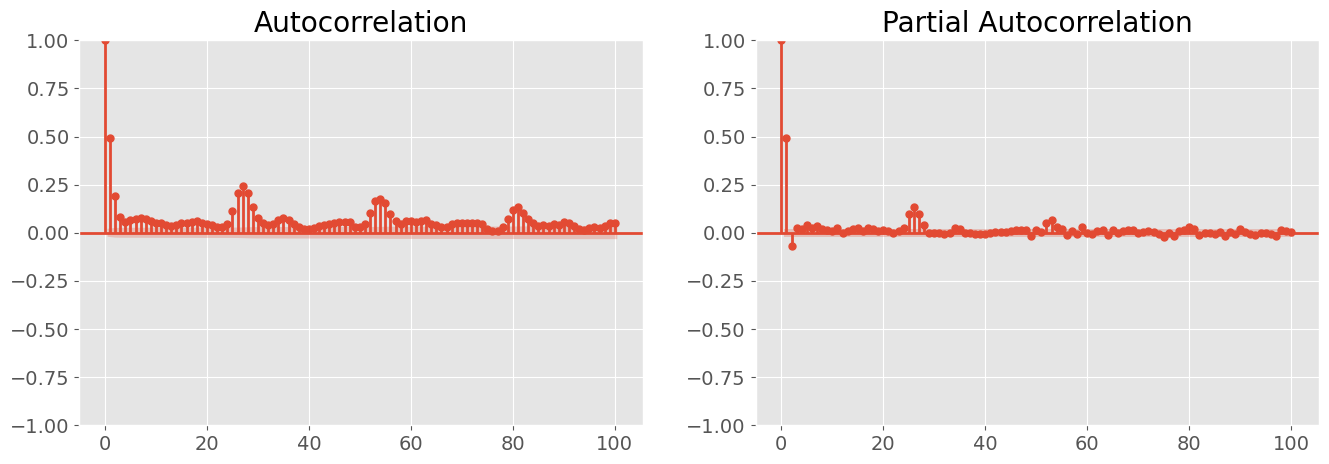

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_acf(daily_max_df_2000["remainder"], lags=100, ax=axes[0])
plot_pacf(daily_max_df_2000["remainder"], lags=100, ax=axes[1]);

Much better with our manual removal, although there seems to be still some autocorrelations at lag 27. 

Let's use the method `STL` to attempt to remove the trends and seasonality. This is a more advanced method of decomposition which stands for Seasonal and Trend decomposition using Loess (locally estimated scatterplot smoothing).

Since the STL method can handle only one seasonality at a time. To address all three, we are going to apply multiple STL decompositions in sequence, removing one seasonal component at a time.

- Step 1: Remove the 27-Day Sun Rotation Seasonality
    - Use STL to decompose the 27-day sun rotation.
    - Subtract the seasonal component from the original data to remove this cycle.
- Step 2: Remove the Yearly (12-Month) Seasonality
    - After removing the 27-day sun rotation, apply another STL decomposition for the 12-month seasonality.
    - Subtract the seasonal component to remove the monthly cycle.
- Step 3: Remove the 11-Year Solar Cycle Seasonality
    - Apply the final STL decomposition for the 11-year solar cycle.
    - Subtract the seasonal component to remove the 11-year cycle.


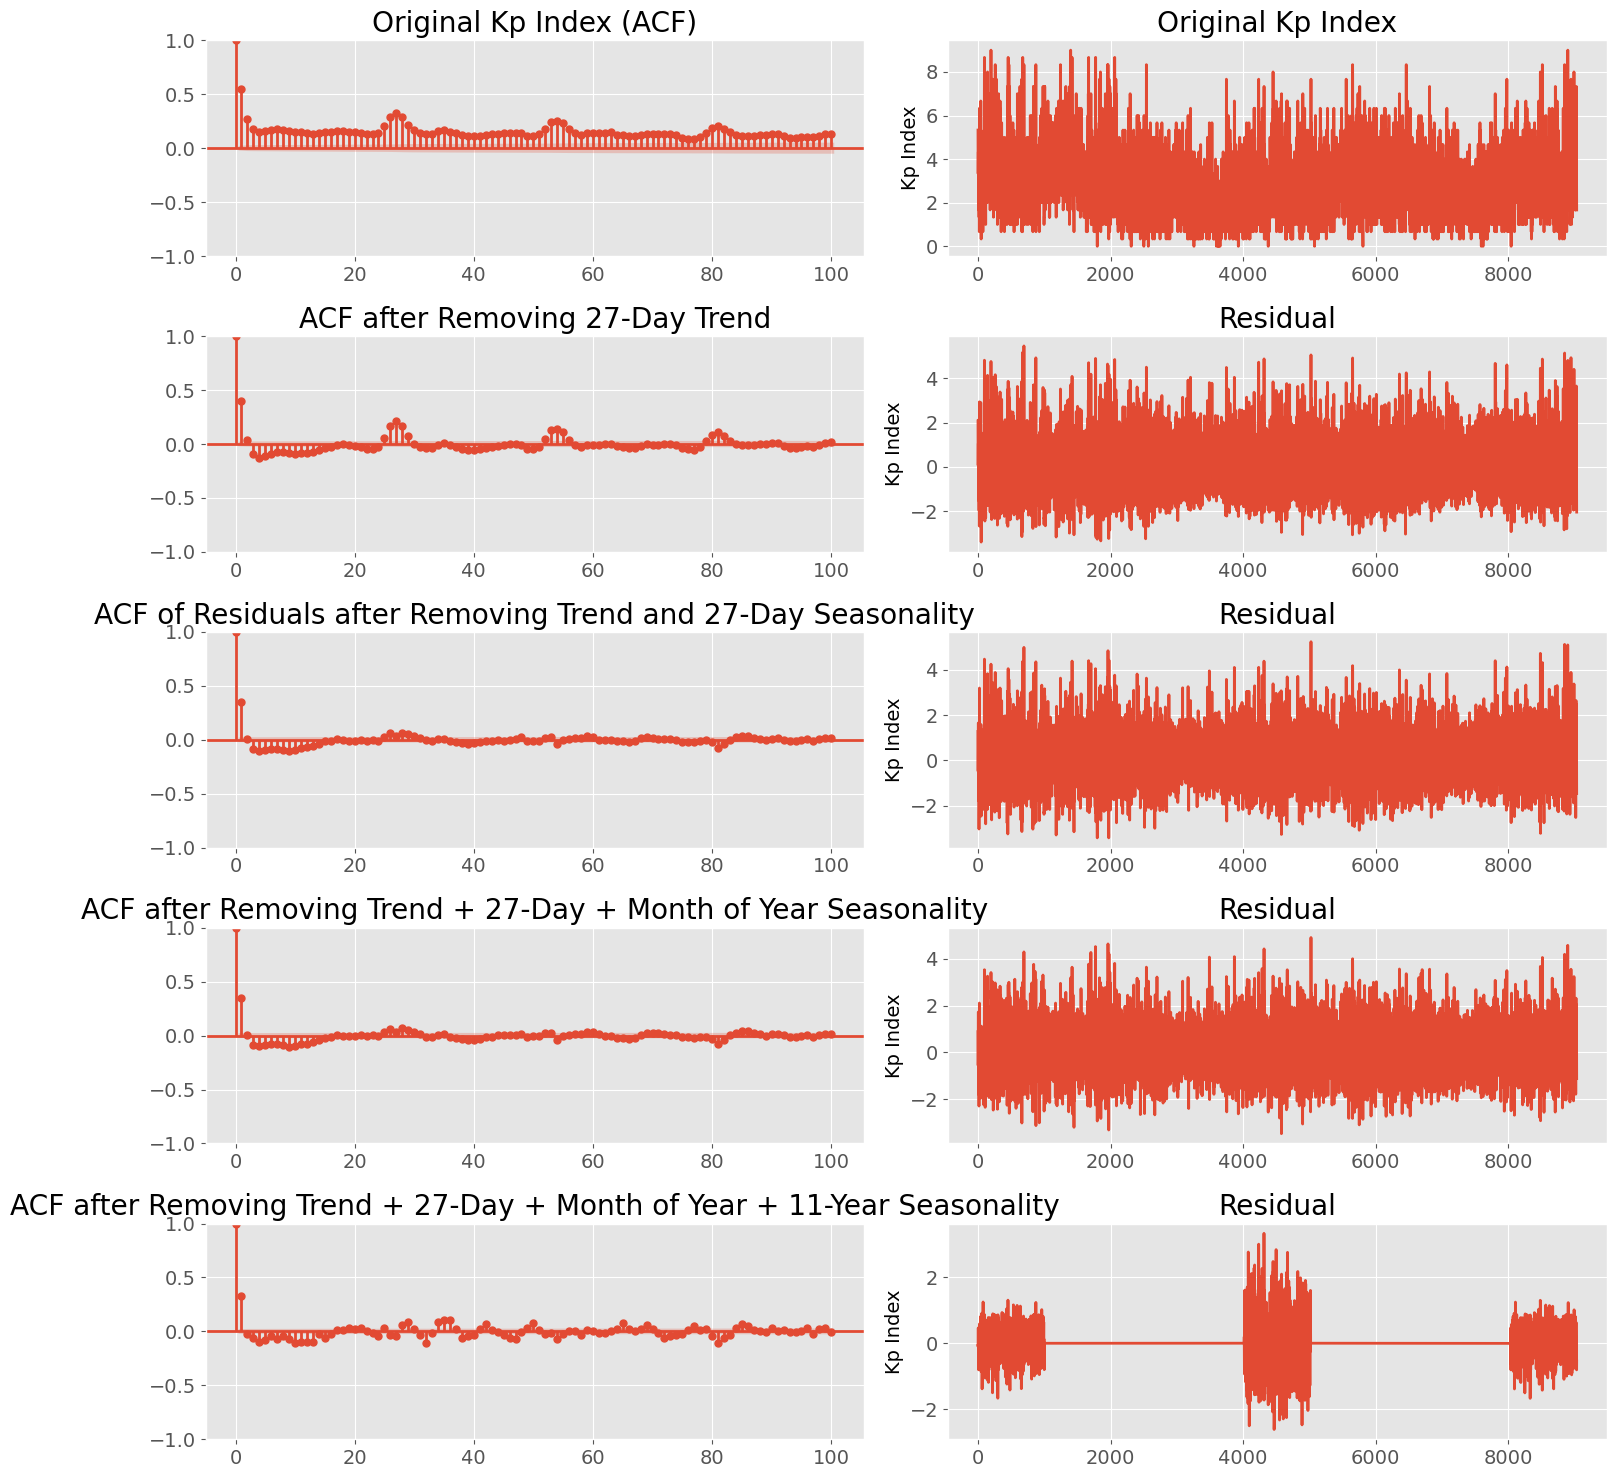

In [32]:
from statsmodels.graphics.tsaplots import plot_acf

# Create subplots with 5 rows and 2 columns: one for ACF plots (left), one for residuals (right)
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

# Step 1: Remove the 27-Day Sun Rotation Trend and Seasonality
stl_27 = STL(daily_max_df_2000['Kp_Index'], period=27, seasonal=27).fit()
daily_max_df_2000['Residual_27'] = daily_max_df_2000['Kp_Index'] - stl_27.trend
daily_max_df_2000['Residual_detrended_27'] = daily_max_df_2000['Residual_27'] - stl_27.seasonal
daily_max_df_2000['Trend_27'] = stl_27.trend
daily_max_df_2000['Seasonal_27'] = stl_27.seasonal

# Step 2: Remove the Month of Year Seasonality (approximately 365.25 days per year and 30.4 days per month)
days_per_year = int(365.25)
days_per_month = int(days_per_year/12)+1 # Make this 31 as the seasonal parameter requires odd number
stl_monthly = STL(daily_max_df_2000['Residual_detrended_27'], period=days_per_year, seasonal=days_per_month).fit()
daily_max_df_2000['Residual_detrended_27_MoY'] = daily_max_df_2000['Residual_detrended_27'] - stl_monthly.seasonal
daily_max_df_2000['Seasonal_MonthofYear'] = stl_monthly.seasonal

# Step 3: Remove the 11-Year Solar Cycle Seasonality
solar_cycle_period = int(11 * days_per_year)  # ~4015 days

stl_11year = STL(daily_max_df_2000['Residual_detrended_27_MoY'], period=solar_cycle_period, seasonal=days_per_year).fit()
daily_max_df_2000['Detrended_Deseasonalized_Kp_Index'] = daily_max_df_2000['Residual_detrended_27_MoY'] - stl_11year.seasonal
daily_max_df_2000['Seasonal_SolarCycle'] = stl_11year.seasonal

# Plot ACF and Residuals side by side

# Original Data
plot_acf(daily_max_df_2000['Kp_Index'], ax=axes[0, 0], lags=100)
axes[0, 0].set_title('Original Kp Index (ACF)')

daily_max_df_2000['Kp_Index'].plot.line(ylabel="Kp Index", title="Original Kp Index", ax=axes[0, 1])

# Step 1: ACF and Residual after removing 27-Day Sun Rotation Seasonality
plot_acf(daily_max_df_2000['Residual_27'], ax=axes[1, 0], lags=100)
axes[1, 0].set_title('ACF after Removing 27-Day Trend')

daily_max_df_2000['Residual_27'].plot.line(ylabel="Kp Index", title="Residual", ax=axes[1, 1])

plot_acf(daily_max_df_2000['Residual_detrended_27'], ax=axes[2,0], lags=100)
axes[2,0].set_title('ACF of Residuals after Removing Trend and 27-Day Seasonality')

daily_max_df_2000['Residual_detrended_27'].plot.line(ylabel="Kp Index", title="Residual", ax=axes[2, 1])

# Step 2: ACF and Residual after removing 27-Day + Month of Year Seasonality
plot_acf(daily_max_df_2000['Residual_detrended_27_MoY'], ax=axes[3, 0], lags=100)
axes[3, 0].set_title('ACF after Removing Trend + 27-Day + Month of Year Seasonality')

daily_max_df_2000['Residual_detrended_27_MoY'].plot.line(ylabel="Kp Index", title="Residual", ax=axes[3, 1])

# Step 3: ACF and Residual after removing 27-Day, Month of Year, and 11-Year Solar Cycle Seasonality
plot_acf(daily_max_df_2000['Detrended_Deseasonalized_Kp_Index'], ax=axes[4, 0], lags=100)
axes[4, 0].set_title('ACF after Removing Trend + 27-Day + Month of Year + 11-Year Seasonality')

daily_max_df_2000['Detrended_Deseasonalized_Kp_Index'].plot.line(ylabel="Kp Index", title="Residual", ax=axes[4, 1])

# Adjust layout
plt.tight_layout()
plt.show()

The detrended and deseasonalized data look very nice. With the residual getting more stationary at each stage. Eventually at the last stage, the residual looks flat. This might due to the 11 year seasonality capturing the data really well, to the point of overfitting even. Or that there leaves little to no variation after removing the 11-year seasonality. 

For our purposes, perhaps we should consider if we need to remove the 11-year seasonality to make the trend completely flat? Perhaps not, we might want data with some variations. 

Thus, for the modelling, let's leave out the 11-year seasonality and go with the first two levels of seasonality removal, which were the 27-days and yearly seasonality. 

In [33]:
daily_max_df_2000['Residual_detrended_27_MoY'].describe()

count    9032.000000
mean        0.000297
std         1.057101
min        -3.473031
25%        -0.726978
50%        -0.068065
75%         0.639680
max         4.916327
Name: Residual_detrended_27_MoY, dtype: float64

Text(0.5, 1.0, 'Rolling std')

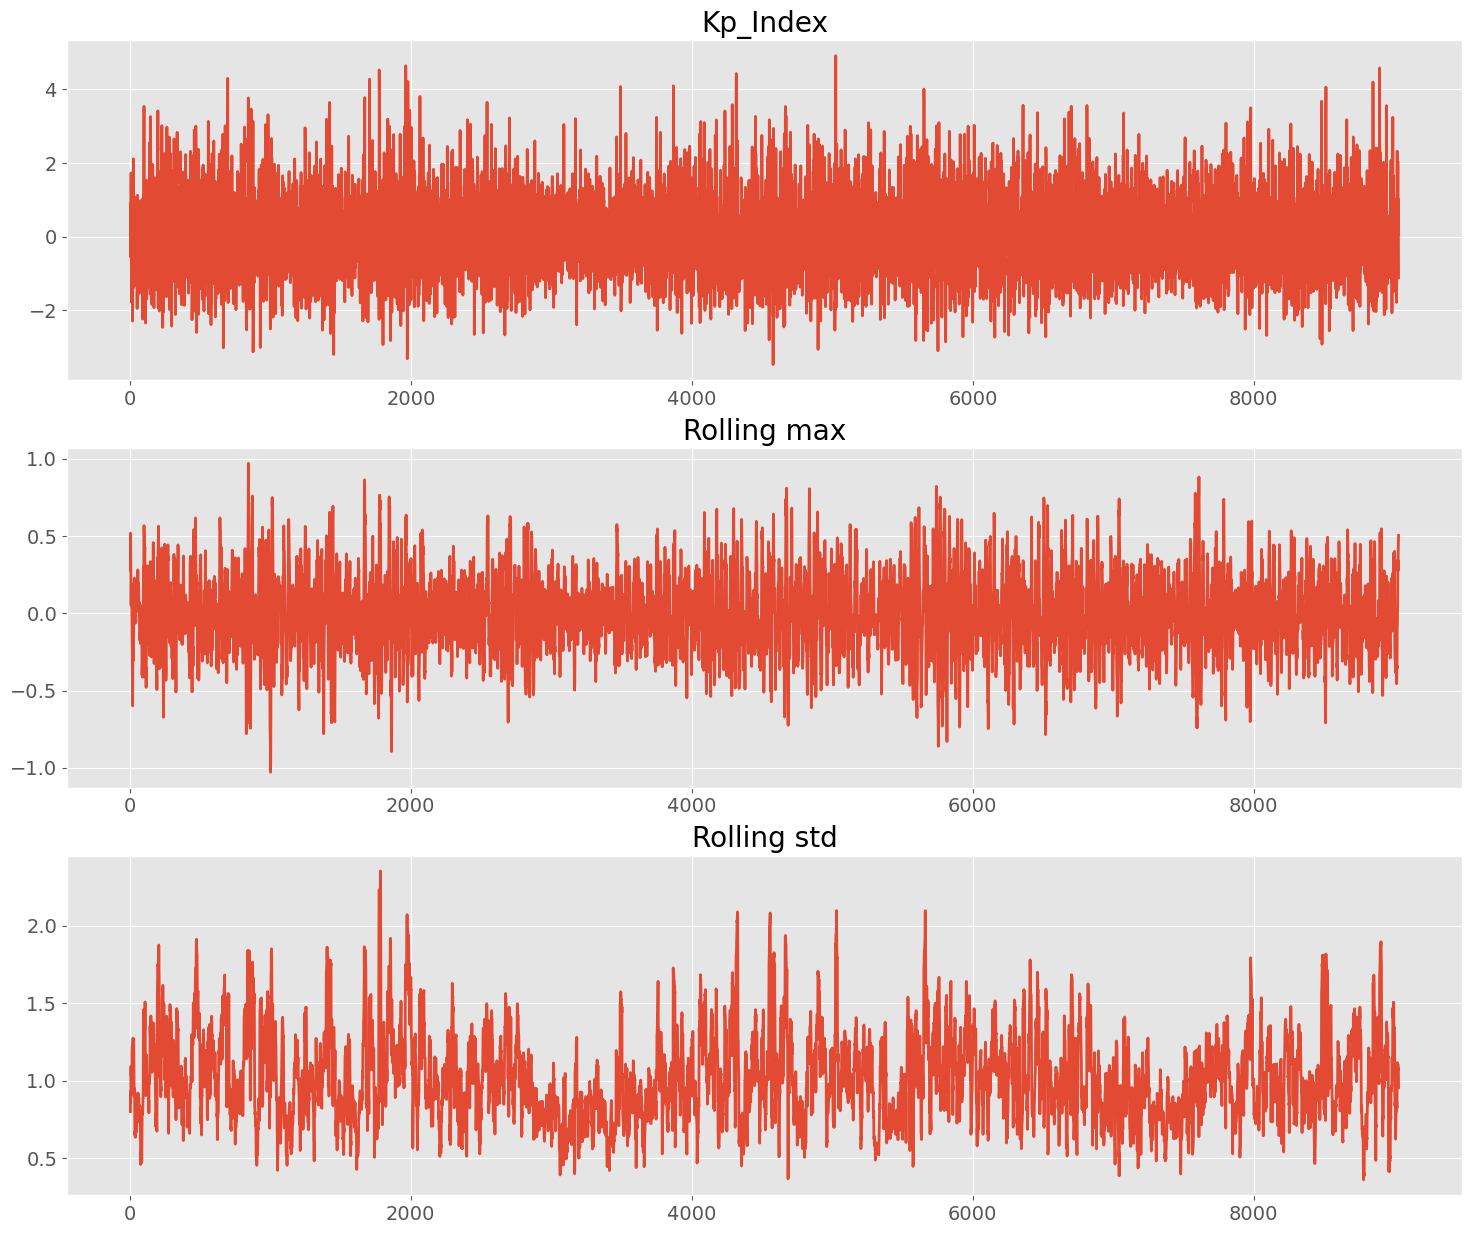

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 15))
wd_size = 14

daily_max_df_2000['Residual_detrended_27_MoY'].plot(ax=axes[0])
axes[0].set_title('Kp_Index')
daily_max_df_2000['Residual_detrended_27_MoY'].rolling(wd_size, min_periods=5).mean().plot(ax=axes[1])
axes[1].set_title('Rolling max')
daily_max_df_2000['Residual_detrended_27_MoY'].rolling(wd_size, min_periods=5).std().plot(ax=axes[2])
axes[2].set_title('Rolling std')

From the rolling mean and standard deviation of the remainder, we can see that the data can be considered stationary now. Let's further employ the Augmented Dickey-Fuller (ADFuller) test to check if the data is stationary. 

In [35]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for original Kp_Index
result_original = adfuller(daily_max_df_2000['Kp_Index'])

# Perform ADF test for detrended residuals
result_detrended = adfuller(daily_max_df_2000['Residual_detrended_27_MoY'])

# Create a DataFrame with ADF statistic and p-values
adf_results = pd.DataFrame({
    'Test': ['Original Kp Index', 'Residual Detrended (27 Days + Month of Year)'],
    'ADF Statistic': [f'{result_original[0]:.2e}', f'{result_detrended[0]:.2e}'],
    'p-value': [f'{result_original[1]:.2e}', f'{result_detrended[1]:.2e}']
})

# Display the DataFrame
adf_results


Test ADF Statistic   p-value
0                             Original Kp Index     -7.34e+00  1.09e-10
1  Residual Detrended (27 Days + Month of Year)     -2.78e+01  0.00e+00

The ADF (Augmented Dickey Fuller) test hypothesizes that the data is non-stationary. Based on the test result, we have enough evidence to reject the null hypothesis (p<0.05).

Let's now clean up the dataset for modeling and forecasting in the next step. 

In [36]:
daily_max_df_2000.columns

Index(['11_Year_Group', 'Day_Sun_rotation', 'Datetime', 'Kp_Index',
       'Poly. fit (order 0)', 'Poly. fit (order 1)', 'Poly. fit (order 2)',
       'detrended', 'Day_of_Month', 'Mean_dayofmonth_peak_Kp',
       'Min_dayofmonth_peak_Kp', 'Max_dayofmonth_peak_Kp', 'Month',
       'Mean_monthly_peak_Kp', 'Min_monthly_peak_Kp', 'Max_monthly_peak_Kp',
       'remainder', 'Day_Sun_rotation_x', 'Year', '11_Year_Group_x',
       'Day_Sun_rotation_y', 'Mean_sunrotation_peak_Kp',
       'Min_sunrotation_peak_Kp', 'Max_sunrotation_peak_Kp', '11_Year_Group_y',
       'Mean_solarcycle_peak_Kp', 'Min_solarcycle_peak_Kp',
       'Max_solarcycle_peak_Kp', 'Residual_27', 'Residual_detrended_27',
       'Trend_27', 'Seasonal_27', 'Residual_detrended_27_MoY',
       'Seasonal_MonthofYear', 'Detrended_Deseasonalized_Kp_Index',
       'Seasonal_SolarCycle'],
      dtype='object')

In [37]:
daily_max_df_2000_cleaned = daily_max_df_2000.drop(
    columns=[
        "Poly. fit (order 0)",
        "Poly. fit (order 1)",
        "Poly. fit (order 2)",
        "detrended",
        "Min_dayofmonth_peak_Kp",
        "Max_dayofmonth_peak_Kp",
        "Min_monthly_peak_Kp",
        "Max_monthly_peak_Kp",
        "remainder",
        "11_Year_Group_x",
        "Day_Sun_rotation_x",
        "Day_Sun_rotation_y",
        "Min_sunrotation_peak_Kp",
        "Max_sunrotation_peak_Kp",
        "11_Year_Group_y",
        "Min_solarcycle_peak_Kp",
        "Max_solarcycle_peak_Kp",
        "Detrended_Deseasonalized_Kp_Index",
    ]
)

daily_max_df_2000_cleaned.head()

11_Year_Group  Day_Sun_rotation   Datetime  Kp_Index  Day_of_Month  \
0              4                 1 2000-01-01     5.333             1   
1              4                 2 2000-01-02     3.333             2   
2              4                 3 2000-01-03     3.333             3   
3              4                 4 2000-01-04     3.667             4   
4              4                 5 2000-01-05     4.000             5   

   Mean_dayofmonth_peak_Kp  Month  Mean_monthly_peak_Kp  Year  \
0                 3.069596      1              2.788832  2000   
1                 2.900118      1              2.788832  2000   
2                 2.780020      1              2.788832  2000   
3                 2.919199      1              2.788832  2000   
4                 2.927017      1              2.788832  2000   

   Mean_sunrotation_peak_Kp  Mean_solarcycle_peak_Kp  Residual_27  \
0                  2.983078                 3.130476     2.078821   
1                  3.012973                 3.130476     0.076035   
2                  2.968164                 3.130476     0.072958   
3                  2.950257                 3.130476     0.403579   
4                  2.884567                 3.130476     0.732885   

   Residual_detrended_27  Trend_27  Seasonal_27  Residual_detrended_27_MoY  \
0               1.278933  3.254179     0.799889                   0.891785   
1              -0.475998  3.256965     0.552033                  -0.024944   
2              -0.467127  3.260042     0.540084                  -0.550411   
3               0.113897  3.263421     0.289682                  -0.267483   
4               1.116557  3.267115    -0.383672                   1.335878   

   Seasonal_MonthofYear  Seasonal_SolarCycle  
0              0.387148             0.961785  
1             -0.451053             0.074115  
2              0.083284            -0.749604  
3              0.381380            -0.500723  
4             -0.219321             0.869832

# 2. Modeling

In [38]:
# Define our df to contain the observed data.
daily_max_df_2000to2023 = daily_max_df_2000_cleaned[daily_max_df_2000_cleaned['Datetime'] < '2024-01-01'].set_index("Datetime")

df_observed = daily_max_df_2000to2023[['Kp_Index']]
df_observed['Label'] = 'Observed'
df_observed.tail()

Kp_Index     Label
Datetime                      
2023-12-27     2.000  Observed
2023-12-28     1.667  Observed
2023-12-29     2.333  Observed
2023-12-30     2.333  Observed
2023-12-31     1.333  Observed

In [39]:
# Creating the forecasting index
def create_forecast_index(start, horizon, freq="D"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Datetime")

forecast_index = create_forecast_index(daily_max_df_2000to2023.index[-1], 365)

forecast_index[:5]

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05'],
              dtype='datetime64[ns]', name='Datetime', freq='D')

## 2.1 Seasonal naive model (average of Sun Rotation and Month of Year seasonalities)

Work completed up to here.
---

My typical approach is as follows

- Naive (seasonally-adjusted if necessary) / Seasonal naive
- ETS (for SES, or Holt, seasonally-adjust if necessary)
- ARIMA
- ML (next lecture)
- Combinations of the above

In [40]:
# Define the length of sun rotation, which is every 27 days.
days_sun_rotation = 27

# Step 1: Seasonal Naive Model of the 27-days seasonality. We use the last 27-days cycle in 2023 to make prediction for 2024.
seasonal_naive_27 = daily_max_df_2000to2023['Kp_Index'][-days_sun_rotation:].reset_index(drop=True)

# Step 2: Seasonal Naive Model for month of the year seasonality. We use the average monthly value from 2023 to make prediction for 2024.
seasonal_naive_month = daily_max_df_2000to2023[daily_max_df_2000to2023['Year'] == 2023].groupby('Month')['Kp_Index'].mean()

# Step 3: Combine the two models to make prediction for 2024.
combined_seasonal_naive = np.zeros(365)

for i in range(len(combined_seasonal_naive)):
    # Identify the day in sun rotation and the month
    current_day_sun_rotation = i % 27
    current_month = (pd.Timestamp('2024-01-01') + pd.Timedelta(days=i)).month
    # Location the contribution from the two models
    kp_27_contribution = seasonal_naive_27.iloc[current_day_sun_rotation]
    kp_month_contribution = seasonal_naive_month.loc[current_month]
    # Average of the two models
    combined_seasonal_naive[i] = (kp_27_contribution + kp_month_contribution) / 2

# Step 4: Create a DataFrame for the predictions
naive_preds_df = pd.DataFrame(
    {"Label": "Seasonal naive forecast", "Kp_Index": combined_seasonal_naive},
    index=forecast_index,
)

px.line(pd.concat((df_observed, naive_preds_df)), y="Kp_Index", color="Label", width=1600)

## 2.2 Mixed Seasonal average model (sun rotation average, month of year average, and 11 year rotation average since 2000)

In [41]:
daily_max_df_2000to2023.tail(1)

11_Year_Group  Day_Sun_rotation  Kp_Index  Day_of_Month  \
Datetime                                                              
2023-12-31              5                18     1.333            31   

            Mean_dayofmonth_peak_Kp  Month  Mean_monthly_peak_Kp  Year  \
Datetime                                                                 
2023-12-31                 3.009642     12              2.594091  2023   

            Mean_sunrotation_peak_Kp  Mean_solarcycle_peak_Kp  Residual_27  \
Datetime                                                                     
2023-12-31                  2.710584                 3.128945     -0.99274   

            Residual_detrended_27  Trend_27  Seasonal_27  \
Datetime                                                   
2023-12-31               -0.97691   2.32574     -0.01583   

            Residual_detrended_27_MoY  Seasonal_MonthofYear  \
Datetime                                                      
2023-12-31                  -0.741523             -0.235387   

            Seasonal_SolarCycle  
Datetime                         
2023-12-31             -0.50563

In [42]:
# Step 1: Calculating the three grouped averages.
sun_rotation = daily_max_df_2000to2023.groupby(daily_max_df_2000to2023['Day_Sun_rotation']).agg(Mean_sunrotation_peak_Kp=('Kp_Index', 'mean'))
month_of_year = daily_max_df_2000to2023.groupby(daily_max_df_2000to2023.index.month).agg(Mean_monthly_peak_Kp=('Kp_Index', 'mean'))
solar_cycle = daily_max_df_2000to2023.groupby(daily_max_df_2000to2023['11_Year_Group']).agg(Mean_solarcycle_peak_Kp=('Kp_Index', 'mean'))

# Step 2: Combine the three averages to make prediction for 2024.
combined_seasonal_average = np.zeros(365)

for i in range(len(combined_seasonal_average)):
    # 2024-01-01 is the 14th day in sun rotation, 1st month in the year, and 7th year in the 11-year group.
    current_day_sun_rotation = (i + 13) % 27 + 1
    current_month = (pd.Timestamp('2024-01-01') + pd.Timedelta(days=i)).month
    current_11_yeargroup = 7
    # Locate the contribution from the three averages
    day_of_sun_contribution = sun_rotation.loc[current_day_sun_rotation]['Mean_sunrotation_peak_Kp']
    month_of_year_contribution = month_of_year.loc[current_month]['Mean_monthly_peak_Kp']
    solar_cycle_contribution = solar_cycle.loc[current_11_yeargroup]['Mean_solarcycle_peak_Kp']
    # Average of the three contributions
    combined_seasonal_average[i] = (day_of_sun_contribution + month_of_year_contribution + solar_cycle_contribution) / 3

# Step 3: Create a DataFrame for the predictions
combined_seasonal_average_preds_df = pd.DataFrame(
    {"Label": "Combined seasonal averages", "Kp_Index": combined_seasonal_average},
    index=forecast_index,
)

px.line(pd.concat((df_observed, naive_preds_df, combined_seasonal_average_preds_df)), y="Kp_Index", color="Label", width=1600)

## 2.3 ETS (Error, Trend, Seasonal) Model

In [43]:
from statsmodels.tsa.api import ETSModel

aan_model = ETSModel(daily_max_df_2000to2023["Kp_Index"], error="add", trend="add", freq="D").fit()
ets_aan = pd.DataFrame({"Kp_Index": aan_model.forecast(len(forecast_index)),
                        "Label": "ETS (AAN)"},
                       index=forecast_index)

aaa_model = ETSModel(daily_max_df_2000to2023["Kp_Index"], error="add", trend="add", seasonal="add", seasonal_periods=27, freq="D").fit()
ets_aaa = pd.DataFrame({"Kp_Index": aaa_model.forecast(len(forecast_index)),
                        "Label": "ETS (AAA)"},
                       index=forecast_index)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72614D+00    |proj g|=  9.99000D-02

At iterate    1    f=  1.69176D+00    |proj g|=  1.39709D-01

At iterate    2    f=  1.68859D+00    |proj g|=  1.49482D-01

At iterate    3    f=  1.68013D+00    |proj g|=  7.97365D-02

At iterate    4    f=  1.67748D+00    |proj g|=  7.33400D-02

At iterate    5    f=  1.66879D+00    |proj g|=  9.88229D-03

At iterate    6    f=  1.66860D+00    |proj g|=  1.08587D-02

At iterate    7    f=  1.66856D+00    |proj g|=  2.32210D-01

At iterate    8    f=  1.66855D+00    |proj g|=  1.25233D-02

At iterate    9    f=  1.66854D+00    |proj g|=  1.28419D-02

At iterate   10    f=  1.66853D+00    |proj g|=  2.75310D-02

At iterate   11    f=  1.66851D+00    |proj g|=  1.20827D-01

At iterate   12    f=  1.66847D+00    |proj g|=  2.70495D-01

At iterate   13    f=  1.6

In [44]:
from sktime.forecasting.ets import AutoETS

autoets_model = AutoETS(auto=True, n_jobs=-1, sp=27, freq="D", random_state = 123)
autoets_model.fit(daily_max_df_2000to2023["Kp_Index"])
ets_auto = pd.DataFrame({"Kp_Index": autoets_model.predict(fh=forecast_index),
                        "Label": "ETS (Auto)"},
                       index=forecast_index)

/opt/miniconda3/envs/mds574/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/miniconda3/envs/mds574/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/miniconda3/envs/mds574/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/miniconda3/envs/mds574/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/miniconda3/envs/mds574/lib/python3.10/s

In [45]:
px.line(pd.concat((df_observed, naive_preds_df, combined_seasonal_average_preds_df, ets_aan, ets_aaa, ets_auto)), y="Kp_Index", color="Label", width=1600)

In [46]:
q = 0.975  # 95% prediction intervals
simulations = aaa_model.simulate(anchor="end", nsimulations=365, repetitions=100, random_errors="bootstrap")
simulations = pd.DataFrame({"median": simulations.median(axis=1),
                            "pi_lower": simulations.quantile((1 - q), axis=1),
                            "pi_upper": simulations.quantile(q, axis=1)},
                           index=forecast_index)

plot_prediction_intervals(df_observed['Kp_Index'], simulations, "median", xlabel="Datetime", ylabel="Kp Index", width=1600)

In [47]:
pd.DataFrame({"AIC": [aan_model.aic, aaa_model.aic],
              "BIC": [aan_model.bic, aaa_model.bic],
              "MSE": [aan_model.mse, aaa_model.mse]},
             index=["(AAN)", "(AAA)"]).round(2)

AIC       BIC   MSE
(AAN)  29237.06  29272.45  1.64
(AAA)  29250.77  29484.36  1.63

## 2.4 TBATS (Trigonometric, Box-Cox, ARMA Errors, Trend, and Seasonal Components):

TBATS can handle multiple seasonalities. You can use the tbats package, which supports complex seasonality (e.g., daily and yearly patterns).

In [48]:
from sktime.forecasting.tbats import TBATS

# The runtime for this model is around 8 minutes. I'm saving it to the models folder.
# # Create a TBATS model
# estimator = TBATS(sp=[27, 365.25])  # Weekly and sun rotation (27-day) seasonality
# tbats_model = estimator.fit(daily_max_df_2000to2023["Kp_Index"])
# tbats_model.save(path="./models/tbats_model")

# Loading a saved TBATS model
estimator = TBATS()
tbats_model = estimator.load_from_path("./models/tbats_model.zip")

In [49]:
tbats_forecast = pd.DataFrame({"Kp_Index": tbats_model.predict(fh=forecast_index),
                        "Label": "TBATS"},
                       index=forecast_index)

px.line(pd.concat((df_observed, naive_preds_df, combined_seasonal_average_preds_df, ets_aaa, tbats_forecast)), y="Kp_Index", color="Label", width=1600)

## 2.5 ARIMA

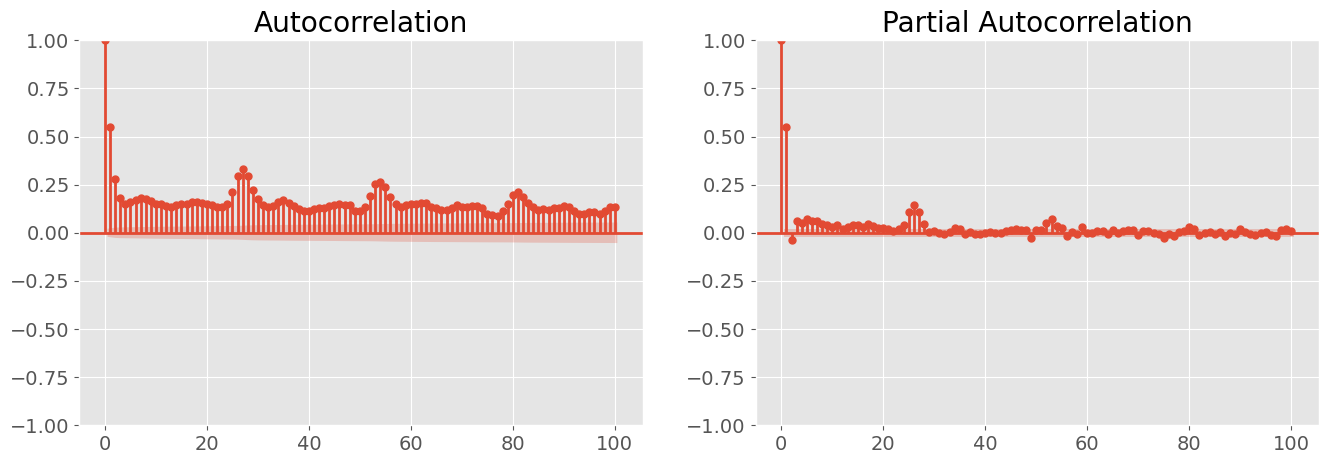

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_acf(daily_max_df_2000to2023["Kp_Index"], lags=100, ax=axes[0])
plot_pacf(daily_max_df_2000to2023["Kp_Index"], lags=100, ax=axes[1]);

From the ACF plot, we can see that the MA(q) value is 1 or 2. From the PACF plot, we can see that the AR(p) value is 1. 

Of course, we can use `AutoARIMA` to help me find the model with the smallest AIC. 

In [51]:
from sktime.forecasting.arima import AutoARIMA

import pmdarima as pm

sarimax = pm.auto_arima(daily_max_df_2000to2023["Kp_Index"], n_jobs = -1, start_q=0,start_d=1,start_p=0,
                            max_q=5, max_d=5, max_p=5, random_state=123)

print(sarimax.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8766
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -13686.030
Date:                Sun, 22 Sep 2024   AIC                          27380.061
Time:                        21:55:44   BIC                          27408.375
Sample:                    01-01-2000   HQIC                         27389.708
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5092      0.010     52.321      0.000       0.490       0.528
ar.L2         -0.1003      0.010     -9.752      0.000      -0.120      -0.080
ma.L1         -0.9842      0.002   -489.096      0.0

The `AutoARIMA` determines the model with AR(2), d=1, and MA(1) has the smallest AIC. Let's use this to train a seasonal ARIMA model.

In [52]:
from statsmodels.tsa.arima.model import ARIMA

# model_sarima = ARIMA(daily_max_df_2000to2023["Kp_Index"], order=(2, 1, 1), seasonal_order=(1, 1, 1, 27)).fit()

In [53]:
# print(model_sarima.summary())

```
SARIMAX Results                                     
========================================================================================
Dep. Variable:                         Kp_Index   No. Observations:                 8766
Model:             ARIMA(2, 1, 1)x(1, 1, 1, 27)   Log Likelihood              -13643.071
Date:                          Sun, 22 Sep 2024   AIC                          27298.143
Time:                                  04:02:26   BIC                          27340.595
Sample:                              01-01-2000   HQIC                         27312.610
                                   - 12-31-2023                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4835      0.010     50.345      0.000       0.465       0.502
ar.L2         -0.0878      0.010     -8.531      0.000      -0.108      -0.068
ma.L1         -0.9860      0.002   -510.783      0.000      -0.990      -0.982
ar.S.L27       0.1117      0.010     11.117      0.000       0.092       0.131
ma.S.L27      -0.9854      0.003   -384.796      0.000      -0.990      -0.980
sigma2         1.3152      0.016     84.226      0.000       1.285       1.346
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1365.89
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
```

In [54]:
# sarima_forecast = pd.DataFrame({"Kp_Index": model_sarima.forecast(len(forecast_index)),
#                         "Label": "SARIMA"},
#                        index=forecast_index)

# px.line(pd.concat((df_observed, naive_preds_df, combined_seasonal_average_preds_df, ets_aaa, tbats_forecast, sarima_forecast)), y="Kp_Index", color="Label", width=1600)

In [55]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
# plot_acf(model_sarima.resid, lags=100, ax=axes[0])
# plot_pacf(model_sarima.resid, lags=100, ax=axes[1]);

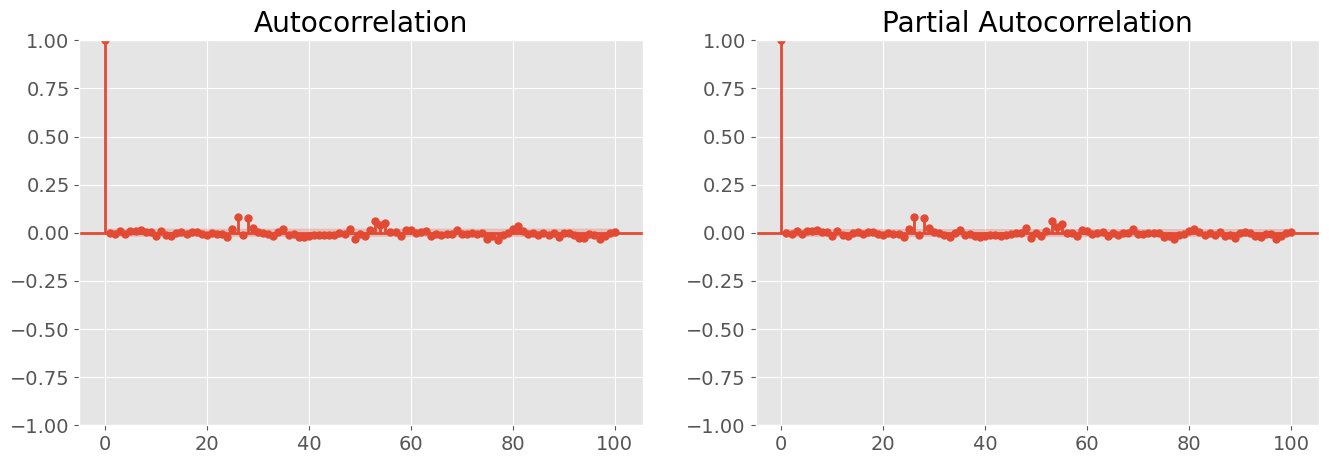

We can see that this model was doing pretty well in capturing the autocorrelation and seasonality of the data. 

# 3. Machine-Learning Modelling

## 3.1 Train-Valid-Test Split

Before building our model, we need to split the data into a training set (for model training) and a test set (to evaluate model performance). As for time-series, this has special consideration as 1) we do not shuffle the data to preserve the temporal component and 2) we use a sliding window approach for cross-validation. 

Training data length: 182
One-fold validation data length: 31
Test data length: 53


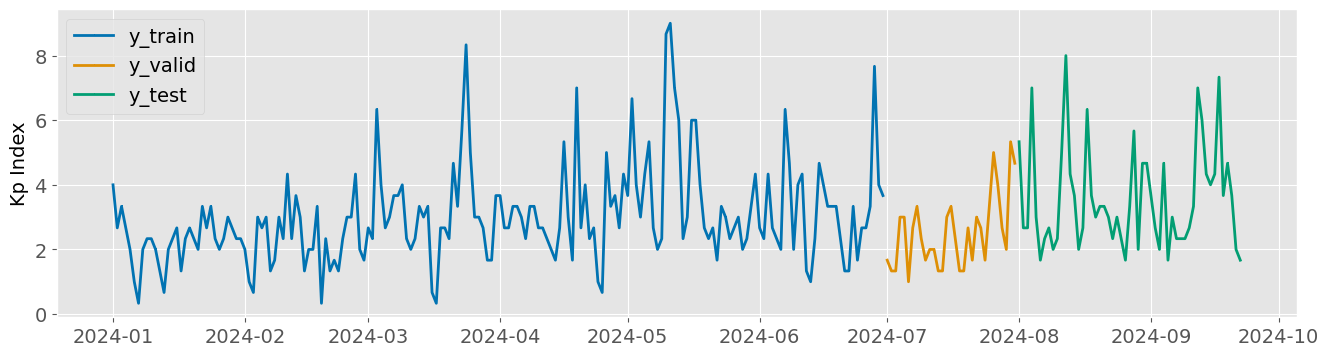

In [56]:
from sktime.forecasting.model_selection import  SlidingWindowSplitter, temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

df = daily_max_df_2000_cleaned.set_index("Datetime")

train_set, valid_set, test_set = df[(df.index >= "2024-01-01") & (df.index < "2024-07-01")], df[(df.index >= "2024-07-01") & (df.index < "2024-08-01")], df[df.index >= "2024-08-01"]
# train_set, valid_set, test_set = df[df.index < "2023-01-01"], df[(df.index >= "2023-01-01") & (df.index < "2024-01-01")], df[df.index >= "2024-01-01"]
X_train, y_train = train_set.drop(columns=['Kp_Index']), train_set['Kp_Index']
X_valid, y_valid = valid_set.drop(columns=['Kp_Index']), valid_set['Kp_Index']
X_test, y_test = test_set.drop(columns=['Kp_Index']), test_set['Kp_Index']
# y_train, y_valid = y_train_valid[y_train_valid.index < "2023-01-01"], y_train_valid[y_train_valid.index >= "2023-01-01"]
fig, ax = plot_series(y_train, y_valid, y_test, labels=["y_train", "y_valid", "y_test"], y_label="Kp Index", markers=[',',',', ','])

# Verify the split
print(f"Training data length: {len(y_train)}")
print(f"One-fold validation data length: {len(y_valid)}")
print(f"Test data length: {len(y_test)}")

So in this split, we are assigning the data from 2024 as unseen test data. This will not be used in model training at all. At the final stage after I have fine-tuned our model, I will then use the test data to evaludate the model's performance. Remember, the golden rule of machine learning is that the algorithm/model should not see the test set until the very last step to report score. 

For the sake of saving training time during coding phase, I will perform one-fold validation on all data from 2023 and the use data before 2023 as the training set. 

In [57]:
# Specify forecast horizon. This has the same length minus one as the test set.
fh = ForecastingHorizon(np.arange(1,len(y_valid)+1))
len(fh)

31

In [58]:
# # For each of the validation fold, we set the training set to 11 years (4015 days) and the validation set to 1 year (365 days).
# cv = SlidingWindowSplitter(window_length=4015, step_length=365, fh=fh)

# n_splits = cv.get_n_splits(y_train)
# print(f"Number of Folds = {n_splits}")

In [59]:
# train_windows, test_windows = get_windows(y_train, cv)

# plot_windows(y_train, train_windows, test_windows)

To explain how the sliding window works, `window = 4015` indicates that I am using every past 11 years's data to predict the 12th year. The `step_length` indicates that I always skip a year before remaking another prediction. This makes some logical sense as in the EDA section, I showed that in every solar cycle, 11 years, the Kp index repeats. 

## 3.2 Direct Model using `make_reduction`

In [60]:
from sktime.forecasting.model_evaluation import evaluate
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction


regressor = KNeighborsRegressor(n_neighbors=1) # specify a sklearn model
forecaster = make_reduction(regressor,  
                            strategy="direct", # specify the fit strategy
                            window_length=27  # specify the window length to create the predictors 
                                              # (e.g. windown_length = 27, the model will use the previous 27 lags as predictors, 
                                              # think of it as X_train = lag 1 to lag 27)
                           )

forecaster.fit(y_train, X=X_train, fh=fh)
y_pred = forecaster.predict(X=X_valid, fh=fh)
# results = evaluate(forecaster=forecaster, y=y_train, cv=cv, strategy="refit", return_data=True)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Kp_Index'>)

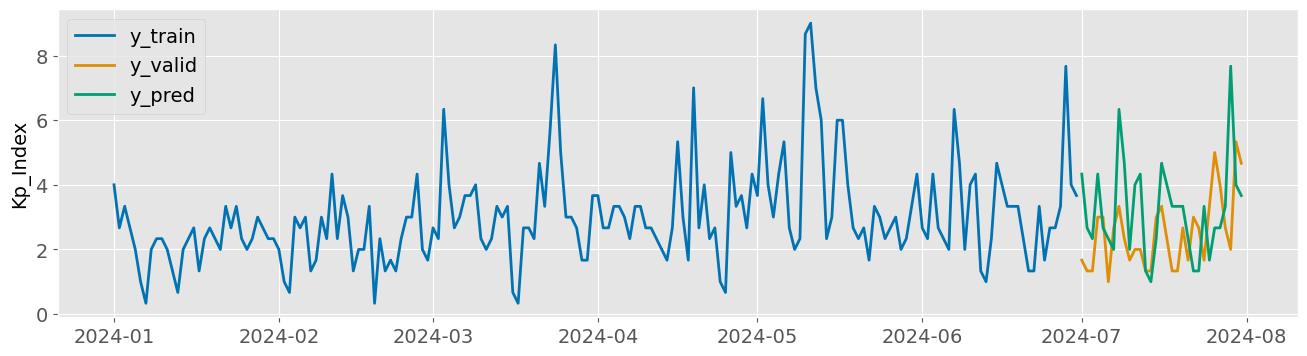

In [61]:
plot_series(y_train, y_valid, y_pred, labels=["y_train", "y_valid", "y_pred"], markers=[',',',', ','])

In [62]:
mean_absolute_percentage_error(y_valid, y_pred)

0.7062814751846103

In [63]:
y_train_plot = pd.DataFrame(y_train)
y_valid_plot = pd.DataFrame(y_valid)
y_pred_plot = pd.DataFrame(y_pred)

y_train_plot['Label'] = "Train"
y_valid_plot['Label'] = "Valid"
y_pred_plot['Label'] = "Pred"

px.line(pd.concat((y_train_plot, y_valid_plot, y_pred_plot)), color="Label", width=1600)

In [64]:
# result_index = -1
# train_result = results["y_train"].iloc[result_index]
# valid_result = results["y_pred"].iloc[result_index]

# train_result['Label'] = "Train"
# valid_result['Label'] = "Reduction"
# px.line(pd.concat((train_result, valid_result)), y="Kp_Index", color="Label", width=1600)

## 3.2 Feature Engineering/Transformation

These transformations will have minimal effects on tree-based models but will help tremendously on linear models. 

In [65]:
X_train.columns

Index(['11_Year_Group', 'Day_Sun_rotation', 'Day_of_Month',
       'Mean_dayofmonth_peak_Kp', 'Month', 'Mean_monthly_peak_Kp', 'Year',
       'Mean_sunrotation_peak_Kp', 'Mean_solarcycle_peak_Kp', 'Residual_27',
       'Residual_detrended_27', 'Trend_27', 'Seasonal_27',
       'Residual_detrended_27_MoY', 'Seasonal_MonthofYear',
       'Seasonal_SolarCycle'],
      dtype='object')

In [66]:
# Continuous features to scale
continuous_features = [
    "Mean_dayofmonth_peak_Kp",
    "Mean_monthly_peak_Kp",
    "Mean_sunrotation_peak_Kp",
    "Mean_solarcycle_peak_Kp",
    "Residual_27",
    "Residual_detrended_27",
    "Trend_27",
    "Seasonal_27",
    "Residual_detrended_27_MoY",
    "Seasonal_MonthofYear",
    "Seasonal_SolarCycle",
]

# Ordinal features
ordinal_features = ["11_Year_Group", "Year"]

In [67]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Cyclical transformer class
class CyclicalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()  # Avoid modifying the original DataFrame
        X_copy['Day_of_Month_sin'] = np.sin(2 * np.pi * X_copy['Day_of_Month'] / 31)
        X_copy['Day_of_Month_cos'] = np.cos(2 * np.pi * X_copy['Day_of_Month'] / 31)
        X_copy['Month_sin'] = np.sin(2 * np.pi * X_copy['Month'] / 12)
        X_copy['Month_cos'] = np.cos(2 * np.pi * X_copy['Month'] / 12)
        X_copy['Day_Sun_rotation_sin'] = np.sin(2 * np.pi * X_copy['Day_Sun_rotation'] / 27)
        X_copy['Day_Sun_rotation_cos'] = np.cos(2 * np.pi * X_copy['Day_Sun_rotation'] / 27)
        return X_copy[['Day_of_Month_sin', 'Day_of_Month_cos', 'Month_sin', 'Month_cos', 'Day_Sun_rotation_sin', 'Day_Sun_rotation_cos']]

    def get_feature_names_out(self, input_features=None):
        return np.array(['Day_of_Month_sin', 'Day_of_Month_cos', 'Month_sin', 'Month_cos', 'Day_Sun_rotation_sin', 'Day_Sun_rotation_cos'])

# Combine everything in a pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), continuous_features),
        ('ordinal', OrdinalEncoder(), ordinal_features),
        ('cyclical', CyclicalTransformer(), ['Day_of_Month', 'Month', 'Day_Sun_rotation']),
    ],
    remainder='drop'  # Drop any features not specified in transformers
)

# Apply the transformation
X_train_transformed = preprocessor.fit_transform(X_train)
X_valid_transformed = preprocessor.transform(X_valid)

# Convert to DataFrame and add Datetime index
X_train_transformed = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())
X_train_transformed.index = X_train.index

X_valid_transformed = pd.DataFrame(X_valid_transformed, columns=preprocessor.get_feature_names_out())
X_valid_transformed.index = X_valid.index


## 3.3 First glance at model performances

In [68]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor

# Define forecasters
forecasters = {
    "NaiveForecaster": NaiveForecaster(strategy="last"),
    "LinearRegression": make_reduction(LinearRegression(), strategy="recursive", window_length=27),
    "KNN": make_reduction(KNeighborsRegressor(n_neighbors=5), strategy="recursive", window_length=27),
    "RandomForest": make_reduction(RandomForestRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "GradientBoosting": make_reduction(GradientBoostingRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "XGBoost": make_reduction(XGBRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "LightGBM": make_reduction(LGBMRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "CatBoost": make_reduction(CatBoostRegressor(n_estimators=100, random_state=123, silent=True), strategy="recursive", window_length=27),
    "SVR": make_reduction(SVR(), strategy="recursive", window_length=27),
    "MLP": make_reduction(MLPRegressor(hidden_layer_sizes=(100,100), max_iter=500, random_state=123), strategy="recursive", window_length=27),
    "ElasticNet": make_reduction(ElasticNet(), strategy="recursive", window_length=27),
}

In [69]:
# Store results
forecasters_results = {}

# Dictionary to store the results
results = {
    'Model': [],
    'MAPE': [],
    'RMSE': [], 
    'R2': []
}

# Train and evaluate all forecasters
for name, forecaster in forecasters.items():
    print(f"Training {name}...")
    forecaster.fit(y_train, X=X_train_transformed, fh=fh)
    
    # Predict
    y_pred = forecaster.predict(X=X_valid_transformed, fh=fh)
    forecasters_results[name]=y_pred
    
    # Append results to the dictionary
    results['Model'].append(name)
    results['MAPE'].append(mean_absolute_percentage_error(y_valid, y_pred))
    results['RMSE'].append(np.sqrt(mean_squared_error(y_valid, y_pred)))
    results['R2'].append(r2_score(y_valid, y_pred))
    
    print(f"Finished Training {name}.")

Training NaiveForecaster...
Finished Training NaiveForecaster.
Training LinearRegression...
Finished Training LinearRegression.
Training KNN...
Finished Training KNN.
Training RandomForest...
Finished Training RandomForest.
Training GradientBoosting...
Finished Training GradientBoosting.
Training XGBoost...
Finished Training XGBoost.
Training LightGBM...
Finished Training LightGBM.
Training CatBoost...
Finished Training CatBoost.
Training SVR...
Finished Training SVR.
Training MLP...
Finished Training MLP.
Training ElasticNet...
Finished Training ElasticNet.


Let's take a look at how each model performs.

In [70]:
pd.DataFrame(results).set_index("Model").sort_values(by="MAPE").style.background_gradient(cmap="Blues", axis=0)

The ideal model would predict the Kp Index with the smallest MAPE and RMSE, and has an R2 score close to +1. So far, looks like LightGBM is winning. MLP and LinearRegression are not doing very well for this task.

In [71]:
# forecasters_results['NaiveForecaster']

plotting_df = pd.concat((y_train_plot, y_valid_plot))

for model, predictions in forecasters_results.items():
    predictions_df = pd.DataFrame(predictions)
    predictions_df['Label'] = model
    plotting_df = pd.concat((plotting_df, predictions_df))

px.line(plotting_df, color="Label", width=1600)

The predictions made by the LinearRegression and MLP models are very off the scale. Looks like the decision tree-based models are doing pretty well on this task. 

Let's do more hyperparameter optimization to fine-tune these models (all under 50% MAPE):

- LightGBM
- XGBoost
- GradientBoosting
- SVR
- RandomForest
- CatBoost

As most of these models are decision tree-based, they don't really require feature transformation such as standscaling or ordinal encoding. We can skip step 3.2 in our fine-tuning step.

In [72]:
# Define forecasters
forecasters = {
    "NaiveForecaster": NaiveForecaster(strategy="last"),
    "LightGBM": make_reduction(LGBMRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "XGBoost": make_reduction(XGBRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "GradientBoosting": make_reduction(GradientBoostingRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "SVR": make_reduction(SVR(), strategy="recursive", window_length=27),
    "RandomForest": make_reduction(RandomForestRegressor(n_estimators=100, random_state=123), strategy="recursive", window_length=27),
    "CatBoost": make_reduction(CatBoostRegressor(n_estimators=100, random_state=123, silent=True), strategy="recursive", window_length=27),
}


In [73]:

# Store results
forecasters_results = {}

# Dictionary to store the results
results = {
    'Model': [],
    'MAPE': [],
    'RMSE': [], 
    'R2': []
}

# Train and evaluate all forecasters
for name, forecaster in forecasters.items():
    print(f"Training {name}...")
    forecaster.fit(y_train, X=X_train, fh=fh)
    
    # Predict
    y_pred = forecaster.predict(X=X_valid, fh=fh)
    forecasters_results[name]=y_pred
    
    # Append results to the dictionary
    results['Model'].append(name)
    results['MAPE'].append(mean_absolute_percentage_error(y_valid, y_pred))
    results['RMSE'].append(np.sqrt(mean_squared_error(y_valid, y_pred)))
    results['R2'].append(r2_score(y_valid, y_pred))
    
    print(f"Finished Training {name}.")

Training NaiveForecaster...
Finished Training NaiveForecaster.
Training LightGBM...
Finished Training LightGBM.
Training XGBoost...
Finished Training XGBoost.
Training GradientBoosting...
Finished Training GradientBoosting.
Training SVR...
Finished Training SVR.
Training RandomForest...
Finished Training RandomForest.
Training CatBoost...
Finished Training CatBoost.


In [74]:
pd.DataFrame(results).set_index("Model").sort_values(by="MAPE").style.background_gradient(cmap="Blues", axis=0)